### Libraries

In [1]:
import warnings as wrn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as GS
from matplotlib.colors import LinearSegmentedColormap as LSC
import seaborn as sns
import random as rnd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR
from sklearn.model_selection import GridSearchCV as GSCV, cross_val_score as CVS

# 1. Baseline Model Development
## a. Baseline Model (from Task 2)

### Getting data from train.csv & test.csv
###### For original model from task 2

In [2]:
# for organization purposes and potential reproducibility
trainCols = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 
             'kitch_sq', 'state', 'product_type', 'sub_area', 'price_doc', 'timestamp']
testCols = ['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 
            'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', 'timestamp']
# getting all relevant features of train & test datasets
SbrBkTrain = pd.read_csv('train.csv', parse_dates=['timestamp']).filter(trainCols)
SbrBkTest = pd.read_csv('test.csv', parse_dates=['timestamp']).filter(testCols)

### Original data cleaning

In [3]:
wrn.filterwarnings('ignore')

# Train data cleaning
# full_sq should be a value between 7 and 500 from my observation
SbrBkTrain.full_sq.loc[SbrBkTrain.full_sq < 7] = np.nan
SbrBkTrain.full_sq.loc[SbrBkTrain.full_sq > 500] = np.nan
# life_sq should be a value between 7 and 300 from my observation
SbrBkTrain.life_sq.loc[SbrBkTrain.life_sq < 7] = np.nan
SbrBkTrain.life_sq.loc[SbrBkTrain.life_sq > 300] = np.nan
# floor should not be a value above 40 from my observation
SbrBkTrain.floor.loc[SbrBkTrain.floor > 40] = np.nan
# max_floor should not be a value above 50 from my observation
SbrBkTrain.max_floor.loc[SbrBkTrain.max_floor > 50] = np.nan
# max_floor should not be a value below the value of floor in the same row
SbrBkTrain.max_floor.loc[SbrBkTrain.max_floor < SbrBkTrain.floor] = np.nan
# build_year should not be before 1800 and above 2020 from my observation
SbrBkTrain.build_year.loc[SbrBkTrain.build_year < 1800] = np.nan 
SbrBkTrain.build_year.loc[SbrBkTrain.build_year > 2020] = np.nan
# num_room should be a value between 1 and 12 from my observation
SbrBkTrain.num_room.loc[SbrBkTrain.num_room < 1] = np.nan
SbrBkTrain.num_room.loc[SbrBkTrain.num_room > 12] = np.nan
# kitch_sq should not be a value below 2 and above 250 from my observation
SbrBkTrain.kitch_sq.loc[SbrBkTrain.kitch_sq < 2] = np.nan
SbrBkTrain.kitch_sq.loc[SbrBkTrain.kitch_sq > 250] = np.nan
# full_sq should not be a value below life_sq in the same row
SbrBkTrain.life_sq.loc[SbrBkTrain.life_sq > SbrBkTrain.full_sq] = np.nan
# full_sq should not be a value below kitch_sq in the same row
SbrBkTrain.kitch_sq.loc[SbrBkTrain.full_sq < SbrBkTrain.kitch_sq] = np.nan
# kitch_sq part of full_sq should not be above life_sq part of full_sq in the same row, as long as full_sq is greater than the sum of life_sq and kitch_sq
SbrBkTrain.kitch_sq.loc[(SbrBkTrain.kitch_sq / SbrBkTrain.full_sq > SbrBkTrain.life_sq / SbrBkTrain.full_sq) & (SbrBkTrain.full_sq >= SbrBkTrain.life_sq + SbrBkTrain.kitch_sq)] = np.nan
# full_sq should not be a value below the sum of life_sq and kitch_sq in the same row
SbrBkTrain.life_sq.loc[SbrBkTrain.full_sq < SbrBkTrain.life_sq + SbrBkTrain.kitch_sq] = SbrBkTrain.full_sq.loc[SbrBkTrain.full_sq < SbrBkTrain.life_sq + SbrBkTrain.kitch_sq] - SbrBkTrain.kitch_sq.loc[SbrBkTrain.full_sq < SbrBkTrain.life_sq + SbrBkTrain.kitch_sq]
# fixing the state values that are incorrect due to misstyping
SbrBkTrain.state.loc[SbrBkTrain.state > 4] = SbrBkTrain.state.loc[SbrBkTrain.state > 4] // 10

# Test data cleaning
# full_sq should be a value between 7 and 500 from my observation
SbrBkTest.full_sq.loc[SbrBkTest.full_sq < 7] = np.nan
SbrBkTest.full_sq.loc[SbrBkTest.full_sq > 500] = np.nan
# life_sq should be a value between 7 and 300 from my observation
SbrBkTest.life_sq.loc[SbrBkTest.life_sq < 7] = np.nan
SbrBkTest.life_sq.loc[SbrBkTest.life_sq > 300] = np.nan
# floor should not be a value above 40 from my observation
SbrBkTest.floor.loc[SbrBkTest.floor > 40] = np.nan
# max_floor should not be a value above 50 from my observation
SbrBkTest.max_floor.loc[SbrBkTest.max_floor > 50] = np.nan
# max_floor should not be a value below the value of floor in the same row
SbrBkTest.max_floor.loc[SbrBkTest.max_floor < SbrBkTest.floor] = np.nan
# build_year should not be before 1800 and above 2020 from my observation
SbrBkTest.build_year.loc[SbrBkTest.build_year < 1800] = np.nan 
SbrBkTest.build_year.loc[SbrBkTest.build_year > 2020] = np.nan
# num_room should be a value between 1 and 12 from my observation
SbrBkTest.num_room.loc[SbrBkTest.num_room < 1] = np.nan
SbrBkTest.num_room.loc[SbrBkTest.num_room > 12] = np.nan
# full_sq should not be a value below life_sq in the same row
SbrBkTest.life_sq.loc[SbrBkTest.life_sq > SbrBkTest.full_sq] = np.nan
# full_sq should not be a value below kitch_sq in the same row
SbrBkTest.kitch_sq.loc[SbrBkTest.full_sq < SbrBkTest.kitch_sq] = np.nan
# kitch_sq part of full_sq should not be above life_sq part of full_sq in the same row, as long as full_sq is greater than the sum of life_sq and kitch_sq
SbrBkTest.kitch_sq.loc[(SbrBkTest.kitch_sq / SbrBkTest.full_sq > SbrBkTest.life_sq / SbrBkTest.full_sq) & (SbrBkTest.full_sq >= SbrBkTest.life_sq + SbrBkTest.kitch_sq)] = np.nan
# full_sq should not be a value below the sum of life_sq and kitch_sq in the same row
SbrBkTest.life_sq.loc[SbrBkTest.full_sq < SbrBkTest.life_sq + SbrBkTest.kitch_sq] = SbrBkTest.full_sq.loc[SbrBkTest.full_sq < SbrBkTest.life_sq + SbrBkTest.kitch_sq] - SbrBkTest.kitch_sq.loc[SbrBkTest.full_sq < SbrBkTest.life_sq + SbrBkTest.kitch_sq]
# fixing the state values that are incorrect due to misstyping
SbrBkTest.state.loc[SbrBkTest.state > 4] = SbrBkTest.state.loc[SbrBkTest.state > 4] // 10

### Original Handling of missing values

##### Viewing precentages of missing values

In [4]:
print(f'Precentages of missing values in Train:\n{(SbrBkTrain.isna().sum() / SbrBkTrain.shape[0] * 100).round(2).sort_values(ascending = False)}')

Precentages of missing values in Train:
kitch_sq        51.97
build_year      47.62
state           44.50
max_floor       36.33
num_room        31.47
material        31.41
life_sq         22.49
floor            0.56
full_sq          0.11
product_type     0.00
sub_area         0.00
price_doc        0.00
timestamp        0.00
dtype: float64


##### Removing unacceptable columns and rows

In [5]:
wrn.filterwarnings('ignore')

SbrBkTrain.drop(columns = ['kitch_sq'], inplace = True)
SbrBkTest.drop(columns = ['kitch_sq'], inplace = True)

SbrBkTrain['toDrop'] = (((SbrBkTrain.build_year.isna()) | (SbrBkTrain.state.isna())) & (SbrBkTrain.isna().sum(axis = 1) > 5))
# marking rows that are randomly selected to be dropped
SbrBkTrain.toDrop[rnd.sample(list((((SbrBkTrain.build_year.isna()) | (SbrBkTrain.state.isna())) & (SbrBkTrain.isna().sum(axis = 1) == 5))[(((SbrBkTrain.build_year.isna()) | (SbrBkTrain.state.isna())) & (SbrBkTrain.isna().sum(axis = 1) == 5))==True].index), 3300)] = True
# dropping all marked rows
SbrBkTrain = SbrBkTrain[~SbrBkTrain.toDrop]
SbrBkTrain.drop(columns = ['toDrop'], inplace = True)

# viewing the precentages again
print(f'Precentages of missing values in Train:\n{(SbrBkTrain.isna().sum() / SbrBkTrain.shape[0] * 100).round(4).sort_values(ascending = False)}')
print(f'Precentages of missing values in Test:\n{(SbrBkTest.isna().sum() / SbrBkTest.shape[0] * 100).round(4).sort_values(ascending = False)}')

Precentages of missing values in Train:
build_year      35.5516
state           31.7073
max_floor       21.6524
life_sq         18.5309
num_room        15.6719
material        15.6073
full_sq          0.1171
floor            0.0121
product_type     0.0000
sub_area         0.0000
price_doc        0.0000
timestamp        0.0000
dtype: float64
Precentages of missing values in Test:
build_year      20.9736
life_sq         19.7860
state            9.0577
max_floor        8.3921
product_type     0.4307
full_sq          0.0392
floor            0.0131
num_room         0.0131
id               0.0000
material         0.0000
sub_area         0.0000
timestamp        0.0000
dtype: float64


### Imputing missing values

In [6]:
wrn.filterwarnings('ignore')

SbrBkTrain['product_typeCode'] = pd.Categorical(SbrBkTrain.product_type).codes
SbrBkTest['product_typeCode'] = pd.Categorical(SbrBkTest.product_type).codes
SbrBkTest.product_typeCode.loc[SbrBkTest.product_typeCode == -1] = np.nan
SbrBkTrain['sub_areaCode'] = pd.Categorical(SbrBkTrain.sub_area).codes
SbrBkTest['sub_areaCode'] = pd.Categorical(SbrBkTest.sub_area).codes

imputedTrainData = KNNImputer(n_neighbors = 20).fit_transform(SbrBkTrain[['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'state', 'product_typeCode', 'sub_areaCode']])
imputedTestData = KNNImputer(n_neighbors = 20).fit_transform(SbrBkTest[['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'state', 'product_typeCode', 'sub_areaCode']])
imputedTrain = pd.DataFrame(imputedTrainData, columns = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'state', 'product_typeCode', 'sub_areaCode'])
imputedTest = pd.DataFrame(imputedTestData, columns = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'state', 'product_typeCode', 'sub_areaCode'])
imputedTrain.drop(columns = ['product_typeCode', 'sub_areaCode'], inplace = True)
# as observed previously all of the features are integers, and they should remain as such
imputedTrain = imputedTrain.round()
imputedTest = imputedTest.round()
imputedTrain = imputedTrain.set_index(SbrBkTrain.index)
imputedTest = imputedTest.set_index(SbrBkTest.index)
imputedTrain['product_type'] = SbrBkTrain.product_type
imputedTest['product_type'] = SbrBkTest.product_type
imputedTrain['sub_area'] = SbrBkTrain.sub_area
imputedTest['sub_area'] = SbrBkTest.sub_area
imputedTrain['price_doc'] = SbrBkTrain.price_doc
imputedTest['id'] = SbrBkTest.id
imputedTrain['timestamp'] = SbrBkTrain.timestamp
imputedTest['timestamp'] = SbrBkTest.timestamp
imputedTest.product_type.loc[imputedTest.product_type.isna()] = np.where(imputedTest.product_typeCode.loc[imputedTest.product_type.isna()] == 0, 'Investment', 'OwnerOccupier')
imputedTest.drop(columns = ['product_typeCode', 'sub_areaCode'], inplace = True)
imputedTrain['logPrice'] = np.log(imputedTrain.price_doc)

In [7]:
print(f'Precentages of missing values in Train:\n{(imputedTrain.isna().sum() / imputedTrain.shape[0] * 100).round(4).sort_values(ascending = False)}')
print(f'Precentages of missing values in Test:\n{(imputedTest.isna().sum() / imputedTest.shape[0] * 100).round(4).sort_values(ascending = False)}')

Precentages of missing values in Train:
full_sq         0.0
life_sq         0.0
floor           0.0
max_floor       0.0
material        0.0
build_year      0.0
num_room        0.0
state           0.0
product_type    0.0
sub_area        0.0
price_doc       0.0
timestamp       0.0
logPrice        0.0
dtype: float64
Precentages of missing values in Test:
full_sq         0.0
life_sq         0.0
floor           0.0
max_floor       0.0
material        0.0
build_year      0.0
num_room        0.0
state           0.0
product_type    0.0
sub_area        0.0
id              0.0
timestamp       0.0
dtype: float64


### Original feature engineering

In [8]:
wrn.filterwarnings('ignore')

imputedTrain['buildingAge'] = imputedTrain.timestamp.dt.year - imputedTrain.build_year
imputedTrain = imputedTrain.assign(roomPerSq = imputedTrain.num_room / imputedTrain.full_sq,
                                   practAging = imputedTrain.buildingAge / imputedTrain.state,
                                   roomSize = imputedTrain.life_sq / imputedTrain.num_room,
                                   heightScore = (imputedTrain.floor - imputedTrain.max_floor * 0.37).abs() / (imputedTrain.max_floor * 0.63 / 10),
                                   lifeRatio = imputedTrain.life_sq / (imputedTrain.full_sq / 10),
                                   month = imputedTrain.timestamp.dt.month)
imputedTest['buildingAge'] = imputedTest.timestamp.dt.year - imputedTest.build_year
imputedTest = imputedTest.assign(roomPerSq = imputedTest.num_room / imputedTest.full_sq,
                                 practAging = imputedTest.buildingAge / imputedTest.state,
                                 roomSize = imputedTest.life_sq / imputedTest.num_room,
                                 heightScore = (imputedTest.floor - imputedTest.max_floor * 0.37).abs() / (imputedTest.max_floor * 0.63 / 10),
                                 lifeRatio = imputedTest.life_sq / (imputedTest.full_sq / 10),
                                 month = imputedTest.timestamp.dt.month)
imputedTrain.heightScore.loc[imputedTrain.heightScore.isna()] = 7
imputedTest.heightScore.loc[imputedTest.heightScore.isna()] = 7

### Original Label encoding

In [9]:
imputedUnion = pd.concat([imputedTrain, imputedTest], ignore_index=True)
prodTypeLbl = LabelEncoder().fit(imputedUnion.product_type)
subAreaLbl = LabelEncoder().fit(imputedUnion.sub_area)
mtrlLbl = LabelEncoder().fit(imputedUnion.material)
stateLbl = LabelEncoder().fit(imputedUnion.state)
imputedTrain.product_type = prodTypeLbl.transform(imputedTrain.product_type)
imputedTest.product_type = prodTypeLbl.transform(imputedTest.product_type)
imputedTrain.sub_area = subAreaLbl.transform(imputedTrain.sub_area)
imputedTest.sub_area = subAreaLbl.transform(imputedTest.sub_area)
imputedTrain.material = mtrlLbl.transform(imputedTrain.material)
imputedTest.material = mtrlLbl.transform(imputedTest.material)
imputedTrain.state = stateLbl.transform(imputedTrain.state)
imputedTest.state = stateLbl.transform(imputedTest.state)

### Original Rescaling

In [10]:
# Rescaling full_sq in imputedTrain and impuedTest
scaledMaxFullSq = imputedUnion.full_sq.max() / 100
imputedTrain.full_sq = imputedTrain.full_sq / scaledMaxFullSq
imputedTest.full_sq = imputedTest.full_sq / scaledMaxFullSq

# Rescaling life_sq in imputedTrain and impuedTest
scaledMaxLifeSq = imputedUnion.life_sq.max() / 100
imputedTrain.life_sq = imputedTrain.life_sq / scaledMaxLifeSq
imputedTest.life_sq = imputedTest.life_sq / scaledMaxLifeSq

# Rescaling build_year in imputedTrain and impuedTest
minBuildYear = imputedUnion.build_year.min()
imputedTrain.build_year = imputedTrain.build_year - minBuildYear
imputedTest.build_year = imputedTest.build_year - minBuildYear

### Original Train/Validation split (without test, because the test dataset represents that)

In [11]:
finalTrain = imputedTrain.copy(deep = True).reset_index(drop = True)
finalTest = imputedTest.copy(deep = True).reset_index(drop = True)

# due to it being a time series it is only appropriate to split the data in a chronological manner
TrainData = finalTrain.loc[:int(finalTrain.shape[0] * 70 / 85), :]
xTrn = TrainData.drop(columns = ['price_doc', 'logPrice', 'timestamp'])
yTrn = TrainData.logPrice
ValidationData = finalTrain.loc[int(finalTrain.shape[0] * 70 / 85):, :]
xVal = ValidationData.drop(columns = ['price_doc', 'logPrice', 'timestamp'])
yVal = ValidationData.logPrice

### Original Random Forest Model

In [12]:
# ftrSlctModel = RFR(n_jobs = -1, random_state = 42)
# ftrSlctModel.fit(xTrn, yTrn)
# imprtnc = ftrSlctModel.feature_importances_
# features = pd.Series(imprtnc, index = xTrn.columns).sort_values(ascending = False)
# features = list(features[features > 0.05].index)

# rndFrstBaseModel = RFR()
# rndFrstParams = {
#     'max_depth': [i for i in range(4, 9, 2)],
#     'n_estimators': [i for i in range(100, 301, 50)],
#     'min_samples_leaf': [i for i in range(3, 10, 3)]
# }

# grdSrcRndFrst = GSCV(rndFrstBaseModel, rndFrstParams, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2)
# grdSrcRndFrst.fit(xTrn[features], yTrn)

# RndFrstModelParams = grdSrcRndFrst.best_params_

# rndFrstOptModel = RFR(**RndFrstModelParams)
# rndFrstOptModel.fit(xTrn[features], yTrn)

### Original XGBoost Model

In [13]:
# xgbBaseModel = GBR()

# xgbParams = {
#     'learning_rate': [i/1000 for i in range(6, 15, 4)],
#     'n_estimators': [i for i in range(100, 301, 100)],
#     'subsample': [i/20 for i in range(13, 18, 2)],
#     'max_depth': [i for i in range(4, 9, 2)],
#     'min_samples_leaf': [i for i in range(3, 18, 7)]
# }

# grdSrcXgb = GSCV(xgbBaseModel, xgbParams, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2)
# grdSrcXgb.fit(xTrn, yTrn)

# xgbModelParams = grdSrcXgb.best_params_

# xgbOptModel = GBR(**xgbModelParams)
# xgbOptModel.fit(xTrn, yTrn)

### backup for creating the models quickly

In [14]:
ftrSlctModel = RFR(n_jobs = -1, random_state = 42)
ftrSlctModel.fit(xTrn, yTrn)
imprtnc = ftrSlctModel.feature_importances_
features = pd.Series(imprtnc, index = xTrn.columns).sort_values(ascending = False)
features = list(features[features > 0.05].index)
RndFrstModelParams = {
    'max_depth': 8,
    'min_samples_leaf': 9,
    'n_estimators': 200
}
rndFrstOptModel = RFR(**RndFrstModelParams)
rndFrstOptModel.fit(xTrn[features], yTrn)
xgbModelParams = {
    'learning_rate': 0.014,
    'max_depth': 8,
    'min_samples_leaf': 10,
    'n_estimators': 300,
    'subsample': 0.65
}
xgbOptModel = GBR(**xgbModelParams)
xgbOptModel.fit(xTrn, yTrn)

GradientBoostingRegressor(learning_rate=0.014, max_depth=8, min_samples_leaf=10,
                          n_estimators=300, subsample=0.65)

## b. Baseline Results
need to discuss the model's performance metrics

therefor need to calculate the model's performance metrics

,Model,MSE,RMSLE,R^2
0,Random Forest Model,0.193226,0.448706,0.411025
1,XGBoost Model,0.181838,0.432900,0.451788


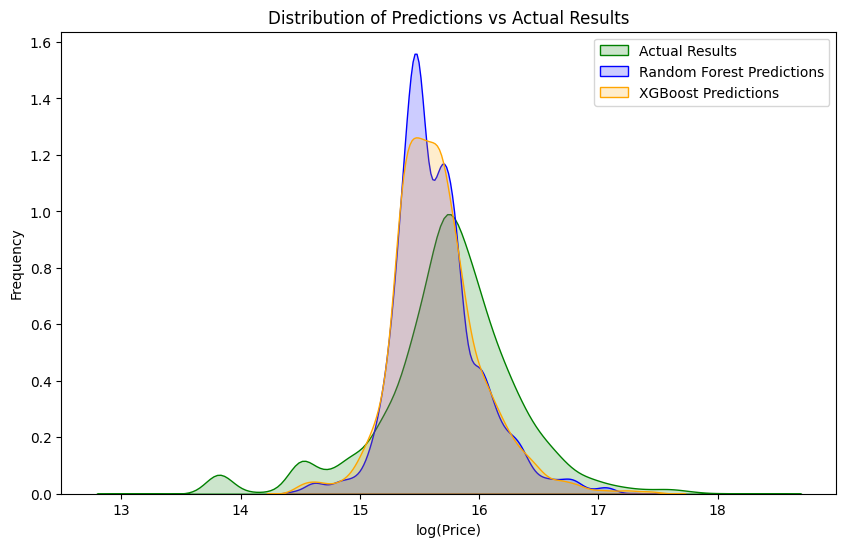

In [15]:
rndFrstMseScores = -1 * CVS(rndFrstOptModel, xVal[features], yVal, cv = 5, scoring = 'neg_mean_squared_error')
# print(f'The mean squared error of the model on the validation set is {rndFrstMseScores.mean()}')
xgbMseScores = -1 * CVS(xgbOptModel, xVal, yVal, cv = 5, scoring = 'neg_mean_squared_error')
# print(f'The mean squared error of the model on the validation set is {xgbMseScores.mean()}')

# Get the logarithmic predictions for the test dataset from both models
rndFrstPred = rndFrstOptModel.predict(xVal[features])
xgbPred = xgbOptModel.predict(xVal)

rndFrstRmsle = np.sqrt(np.mean((rndFrstPred - yVal) ** 2))
xgbRmsle = np.sqrt(np.mean((xgbPred - yVal) ** 2))
# print(f'\nThe root mean squared logarithmic error of the Random Forest model on the validation set is {rndFrstRmsle}')
# print(f'The root mean squared logarithmic error of the XGBoost model on the validation set is {xgbRmsle}')

rndFrstR2 = rndFrstOptModel.score(xVal[features], yVal)
xgbR2 = xgbOptModel.score(xVal, yVal)
# print(f'\nThe R^2 score of the Random Forest model on the validation set is {rndFrstR2}')
# print(f'The R^2 score of the XGBoost model on the validation set is {xgbR2}')

metrics = pd.DataFrame({'Model': ['Random Forest Model', 'XGBoost Model'], 
                        'MSE': [rndFrstMseScores.mean(), xgbMseScores.mean()], 
                        'RMSLE': [rndFrstRmsle, xgbRmsle], 
                        'R^2': [rndFrstR2, xgbR2]})
display(metrics)

plt.figure(figsize=(10, 6))
sns.kdeplot(yVal, color = 'green', fill = True, alpha = 0.2, label='Actual Results')
sns.kdeplot(rndFrstPred, color = 'blue', fill = True, alpha = 0.2, label='Random Forest Predictions')
sns.kdeplot(xgbPred, color = 'orange', fill = True, alpha = 0.2, label='XGBoost Predictions')
plt.xlabel('log(Price)')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions vs Actual Results')
plt.legend()
plt.show()

We can see here there is there alot of overlap between the actual values and the predicted values using both models but the XGBoost seem to better fit the data

### Kaggle Submission

In [16]:
# export random forest model
yPredRndFrst = np.round(np.exp(rndFrstOptModel.predict(finalTest[features])), decimals = -3)
rndFrstSubmission = pd.DataFrame({'id': finalTest.id, 'price_doc': yPredRndFrst})
rndFrstSubmission.to_csv('RandomForestSubmission.csv', index = False)

# export xgboost model
yPredXgb = np.round(np.exp(xgbOptModel.predict(finalTest[[col for col in finalTest.columns if col not in ['id', 'timestamp']]])), decimals = -3)
xgbSubmission = pd.DataFrame({'id': finalTest.id, 'price_doc': yPredXgb})
xgbSubmission.to_csv('XGBoostSubmission.csv', index = False)

when submitting the predictions test data we get the the following results:
|  | Private Score | Public Score |
| - | - | - |
| Random Forest Model | 0.38083 | 0.38305 |
| XGBoost Model | 0.36470 | 0.36667 |

here as well the XGBoost Model fits better than the random forest moedl

# 2. Notebook Analysis
## a. Notebook Selection

we chose the notebooks called: 
- Simple Exploration Notebook - Sberbank
- Feature Engineering & Validation Strategy | Kaggle

delete later

- 'basic-time-series-analysis-feature-selection.ipynb' (correlation matrix)



## b. Analysis Summary
We noticed several things that are worth mentioning
### **Simple Exploration Notebook - Sberbank**
- **Price Transformation Logarithmic Form**
    
    SRK (the author of these notebooks) made an observation on the distribution of price_doc and noticed that it is very right-skewed, so he decided to transform it, and later on model on the log-Price instead on the original price.
- **Median Price Change Across Time**
    
    SRK attempted to identify price changes over the different year & month combinations that are present in the data using a barplot of the median price in each year & month combination.

    In this graph there seem to be some relation, but further on in the second notebook it is clearer that this is not the case.
- **Missing Values**
    
    SRK uses a horizontal barplot to view the amounts of missing values in each column, and he finds that there is there some grouping effect over the missing values of diffeent columns, different columns have the same amount of missing values (seemingly atleast).
- **Top 5 Highest Importance Features (HI Features)**
    
    SRK finds the top 5 highest importance features, which are:
    1. $full\_sq \;\;\;\;\;\;\;\:\, importance = 1677$
    2. $life\_sq \;\;\;\;\;\;\;\;\, importance = 708$
    3. $floor \;\;\;\;\;\;\;\;\;\;\;\, importance = 670$
    4. $max\_floor \;\;\, importance = 460$
    5. $build\_year \;\;\:\, importance = 431$
- **Visual Relation of Top 5 HI Features With Price**

    To better understand the relationships of these top 5 HI features, SRK creates several kinds of graphs to see and describe the interpertation of log-Price across the changing values of these features.
    
    1. <u>full_sq:</u> 
    - ***[1D]Distribution-Scatter Joinplot*** of the log-Full_sq and log_Price, and there seem to be some linear relation expressed between them.
    2. <u>life_sq:</u> 
    - ***[1D-2D]Distribution Joinplot*** of the log-Life_sq and log_Price, and it very noticeable that there are many values in log-Life_sq that equal to 0, and are practically separate from many other values, meaning many of life_sq values equal to 1 or close to 1, are there might be some error in these samples.
    3. <u>floor:</u> 
    - ***[1D]Countplot*** of floor, it seem to be right-skewed in jumps.
    - ***Pointplot*** of floor and median-Price, the higher the floor the higher the median-Price (generally) rises where it peeks at 33.
    4. <u>max_floor:</u>
    - ***[1D]Countplot*** of max_floor, it is raised for consideration that some normalization might be needed for the floor and max_floor features.
    - ***Boxplot*** of max_floor and median-Price, seem fairly expected after knowing all of the previous information.

#### **Feature Engineering & Validation Strategy | Kaggle**
- **Importing the Data with Additional Macro-Economic Features**

    Not like in his previous notebook, in this notebook SRK imports the data and adds to the train dataset and the test dataset additional macro-economic features that are in the macro.csv file, this would expand his options in picking the features to model apon.
- **Categorical Features Conversion - Label Encoding**

    SRK converts the categorical features to numerical using label encoding to be able further on to test their importance and affect on the price.
- **Missing Values Features**

    SRK knows from his previous notebook that some behaviour is displayed across the missing values, so here he makes a new feature that represents the amount of missing values in each row, where potentially this could have an affect on the model.

    right after that he fills all the missing values with -99, this value is highly unlikely, and due to the use of XGBoost and Random Forest models these values are very descernable by the trees, and further more, could be handled appropriately according to them being a missing value.
- **Timestamp Derived Features**
    
    The timestamp feature is of either character, datetime or (after some tranformation) int dtype, all 3 of these dont properly represent the full interpertation of the feature that could be important to the model, such as the year, year & month combination, month of the year, year & week combination, week of the year, day of the week and potentially many others,

    SRK derives several features out of the timestamp feature and plots each of their relation with price, here it is clearer that they dont have any clear relation that is usefull to the model.
- **Top 5 HI Features Derived Features**

    According to the previous notebook top 5 HI features, SRK creates and tests some features that could be derived from these features.

    - from full_sq and life_sq he tries to create some ratio features and difference features, all of which dont seem to be of any help.
    - from floor and max_floor he tries as well to create some ration features and difference features, these he doesnt seem to particulary test in any visual way like previously.
    - from build_year he creates a building age feature, also not tested.
    - out of the timestamp features he created previously he creates supply & demand features that represent aproximatly how many apartments were available and were sold in a specific year & month/week combination
    - further on he starts creating features that are generaly logical to take into acount when pricing an apartment, such as the ratio of children in school or preschool over the school and preschool quotas.
- **Model Generation & Importance Testing**

    After all of this feature engineering, SRK made an XGBoost model using the XGBoost package with some preset hyper-parameters over all of the features he has in he's data and tested it over a validation dataset he created prior to that, this model has trained on the train dataset again and again untill its rmse results havent decreased significantly for 50 rounds, and right after that he ploted the importance of the top 50 features.

    here we see that only full_sq and floor remained in the top 5 HI features, and that full_sq has a significantly high importance score compared to all other features, and he gives a warning that adding many variables will degrade the performance of the model.

## c. Critique and Improvements
### **Simple Exploration Notebook - Sberbank**
SRK gave a fairly detailed data exploration methodology and some vary compeling observations that helped him further on in the exploration and in his next notebook when he did the feature engineering and modeling.

while he gave many observations that helped in the further process he made in his next notebook, he completely missed or ignored many observations about missing values, skewing values and illogical values that are present in the features, which are fairly important to the machine learning pre-processes as they are indications for needed actions at the data cleaning stage.

all of these problematic values in the data are noticeble in hes exploration, and he only comments on tiny parts of them and does not handle them almost at all.

without proper data cleaning prior to modeling, the resulting model will become worse and worse the 'dirtier' the data is, as there is more prominant noise for the model to catch and treat it as a behaviour represented in the data, thus becoming more and more off-course.

skewing values are noticeble at:
- log-Price's Distribution graph, where there are 2 relatively high spikes to the left of the distribution, which should potentially be considered outliers, and smoothed before modeling.
- log-Life_sq's & log-Price's [1D-2D]Distribution graph, where in the left side of the distribution we see a high and unusual spike, which heavily skewes the distribution of log-Life_sq and life_sq as well.

illogical values are noticeble at:
- log-Full_sq's & log-Price's [1D]Distribution-Scatter graph, where we see among the dots groups of dots with the exact same log-Full_sq value or the exact same log-Price value, something that is highly unlikely to happen, especially to this sizes of groups that we can see are creating almost completely continuous lines.

missing values are mentioned in its own graph but there is no observation made for the potential relationships the groups SRK mentions has and these relationships' affect on the model created later on.

### **Feature Engineering & Validation Strategy | Kaggle**
SRK gave here as well fairly good examples, this time in the process of feature engineering.

the first noticeble (and in our eyes significant) difference, as mentioned in task 2.b., is the addition of the macro-economic features to the datasets to use them as important inforamtional features to create with other derived features.

here SRK starts with setting the values of all the prices that are higher in their value than the 99th precentile value as that 99th precentile value, and aswell for the 1st precentile for the prices that are lower in value from it, we dont agree with doing so because it creates an abnormality that affects the modeling and makes it a tad-bit 'clearer' that there is there some significant behaviour that happens in these 1st and 99th precentiles that in actuality does not exist, such a behaviour now would be easier to catch for the trees in the model, while this behaviour has been manually manifactured.

it would be better to decide whether to delete these samples or perform winsorization on them, instead of setting their value like that.

right after this, he performs label encoding, which is needed here in our opinion, but we see an issue with the performance, there is no consideration for missing values, misspelled values or any other problematic value that could be in a categorical feature, instead we think there should be done some proper data cleaning (as mentioned over at the previous notebook) so the label encoding would not be compromised with its values.

next there is a very creative, informative and inovative feature engineering in accordance to the different features and also with the amounts of missing values in a sample, after keeping such a feature SRK replaces all of the missing values with -99, this as some sort of a flag for the XGBoost or Random Forest models of a missing value, this should be possible for the models to recognise as explained over at the previous notebook, and is a great additional way to use the information that could come out from using missing values like that.

further more, in the rest of this notebook SRK does not check and give any consideration for removing 'volatile' features which have over 50% (or other any other threashold) missing values, which should be taken care of before the start of the modeling.

for us one more thing is missing before modeling and seeing the importance levels of the features and that is some form of feature filtering, we believe that the use of a correlation matrix is needed here and according to it SRK should have filtered all but one chosen arbitrarily out of each group of highly correlated features, this way we decrease (pretty sure significantly) the features that act as 'noise catchers'.

# 3. Model Enhancement
Prior to feature engineering, we need to perform our preprocessing after learning from the techniques used in the notebooks, and in addition some of our own ideas and opinions

in addition, please notice that across the preprocessing, data engineering, the model generation and its performance comparison there are comments and explanation of the development process of the enhanced model as required in sub-task b
## Pre-Processess
### Data Import
this time we want to import the macro features that exist in the macro file as done in SRK's notebook ***'Feature Engineering & Validation Strategy | Kaggle'***, and use them in our feature engineering further on

In [17]:
SbrBkEnhncTrain = pd.read_csv('train.csv', parse_dates=['timestamp']).filter(['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', 'price_doc', 'timestamp'])
SbrBkEnhncTest = pd.read_csv('test.csv', parse_dates=['timestamp']).filter(['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', 'timestamp'])
SbrBkEnhncTrain = pd.merge(SbrBkEnhncTrain, pd.read_csv('macro.csv', parse_dates=['timestamp']), how = 'left', on='timestamp')
SbrBkEnhncTest = pd.merge(SbrBkEnhncTest, pd.read_csv('macro.csv', parse_dates=['timestamp']), how = 'left', on='timestamp')

### Data Cleaning
#### handling missing values

In [18]:
res = (SbrBkEnhncTrain.isna().sum() / SbrBkEnhncTrain.shape[0] * 100).round(2).sort_values(ascending = False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f'Precentages of missing values in Train:\n{res}\n')

print(f'Number of rows with missing values in Train: {SbrBkEnhncTrain.isna().any(axis = 1).sum()}')
print(f'Precentage of missing values overall in Train: {SbrBkEnhncTrain.isna().sum().sum() / (SbrBkEnhncTrain.shape[0] * SbrBkEnhncTrain.shape[1]) * 100:.3f}%')

Precentages of missing values in Train:
provision_retail_space_modern_sqm             97.53
provision_retail_space_sqm                    81.65
museum_visitis_per_100_cap                    55.47
theaters_viewers_per_1000_cap                 55.47
load_of_teachers_preschool_per_teacher        55.47
students_reg_sports_share                     55.47
build_year                                    44.65
state                                         44.50
max_floor                                     31.41
material                                      31.41
num_room                                      31.41
kitch_sq                                      31.41
life_sq                                       20.95
old_education_build_share                     18.35
modern_education_share                        18.35
electric_stove_share                          10.63
hot_water_share                               10.63
heating_share                                 10.63
old_house_share         

We can see here that in 8 out of the 112 features we have available in the train dataset, over 37% of the values in them are missing values. 

to us this is an indication that these features will bring more noise to the model further on then contribute effectively, so we'll remove them

The features that we'll remove and the precentages of missing values in them are:
- $provision\_retail\_space\_modern\_sqm \;\;\;\;\;\;\:\:\, missing=97.53\%$
- $provision\_retail\_space\_sqm \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\:\, missing=81.65\%$
- $museum\_visitis\_per\_100\_cap \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; missing=55.47\%$
- $theaters\_viewers\_per\_1000\_cap \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\, missing=55.47\%$
- $load\_of\_teachers\_preschool\_per\_teacher \;\: missing=55.47\%$
- $students\_reg\_sports\_share \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\:\,\, missing=55.47\%$
- $build\_year \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\: missing=44.65\%$
- $state \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\: missing=44.50\%$

notes: 
- build_year has been removed here even though it was found as one of the top 5 HI features in *Simple Exploration Notebook - Sberbank*, this is because we prefer to lose that feature than use it and forgive over the noise or unwarented skewness it could give due to the missing values being imputed in some way, we could keep it and remove all or some of the rows that contain missing values in that feature, but this aswell is a high cost in our opinion, which we do not want to pay.
- kitch_sq should be removed aswell due to an observation in our baseline model preprocessing of this project.

In [19]:
colsToDrop = res.loc[res > 37].index
SbrBkEnhncTrain.drop(columns = colsToDrop, inplace = True)
SbrBkEnhncTrain.drop(columns = ['kitch_sq'], inplace = True)
SbrBkEnhncTest.drop(columns = colsToDrop, inplace = True)
SbrBkEnhncTest.drop(columns = ['kitch_sq'], inplace = True)
print(f'{SbrBkEnhncTrain.shape[1]-1} features are left in the dataset.\n')
print(f'Number of rows with missing values in Train: {SbrBkEnhncTrain.isna().any(axis = 1).sum()}')
print(f'Precentage of missing values overall in Train: {SbrBkEnhncTrain.isna().sum().sum() / (SbrBkEnhncTrain.shape[0] * SbrBkEnhncTrain.shape[1]) * 100:.3f}%')

102 features are left in the dataset.

Number of rows with missing values in Train: 16157
Precentage of missing values overall in Train: 4.989%


this seems better!, now we should handle any illogical values.

for example:
- full_sq is not in the range (7, 500)
- life_sq is not in the range (7, 300)
- life_sq is greater than full_sq
- the average size of a room in the apartment is smaller than 2
- the floor of the apartment is higher than the max_floor in the building
- num_room is not in the range (1, 12)

notes:
- it should be mentioned that missing values has not been handled yet, and will be handled further on, but to try and find the illogical values before that they've been temporarily set to be an absurd value only for the search for illogical values

In [20]:
temp_df = SbrBkEnhncTrain.copy(deep = True)
temp_df.fillna(-99, inplace = True)

illogicalTrain_df = pd.DataFrame({
    'illogicalFull_sq': (temp_df['full_sq'] < 7) | (temp_df['full_sq'] > 500),
    'illogicalLife_sq': (temp_df['life_sq'] < 7) | (temp_df['life_sq'] > 300),
    'illogicalLifeGreatFull': (temp_df['life_sq'] > temp_df['full_sq']) & (temp_df['full_sq'] != -99) & (temp_df['life_sq'] != -99),
    'illogicalLifeSize': (temp_df['life_sq'] / temp_df['num_room'] < 2) & (temp_df['life_sq'] != -99) & (temp_df['num_room'] != -99),
    'illogicalMax_floor': (temp_df['floor'] > temp_df['max_floor']) & (temp_df['max_floor'] != -99) & (temp_df['floor'] != -99),
    'illogicalNum_room': ((temp_df['num_room'] < 1) | (temp_df['num_room'] > 12)) & (temp_df['num_room'] != -99)
})

print(f'Precentages of illogical values in Train:\n{(illogicalTrain_df.sum() / illogicalTrain_df.shape[0] * 100).sort_values(ascending = False)}\n')
print(f'Number of rows with illogical values in Train: {illogicalTrain_df.any(axis = 1).sum()}')
print(f'Precentage of missing values overall in Train: {SbrBkEnhncTrain.isna().sum().sum() / (SbrBkEnhncTrain.shape[0] * SbrBkEnhncTrain.shape[1]) * 100:.3f}%')

Precentages of illogical values in Train:
illogicalLife_sq          22.408191
illogicalMax_floor         4.899741
illogicalLifeSize          1.401332
illogicalLifeGreatFull     0.121427
illogicalFull_sq           0.111582
illogicalNum_room          0.052509
dtype: float64

Number of rows with illogical values in Train: 7286
Precentage of missing values overall in Train: 4.989%


Out of all of the train data there are 7286 rows that have any illogical values in them, we can afford to remove these rows and sacrifice the contribution they could potentially hold.

we should check the same in the test!

In [21]:
wrn.filterwarnings('ignore')

temp_df = SbrBkEnhncTest.copy(deep = True)
temp_df.fillna(-99, inplace = True)

illogicalTest_df = pd.DataFrame({
    'illogicalFull_sq': (temp_df['full_sq'] < 7) | (temp_df['full_sq'] > 500),
    'illogicalLife_sq': (temp_df['life_sq'] < 7) | (temp_df['life_sq'] > 300),
    'illogicalLifeGreatFull': (temp_df['life_sq'] > temp_df['full_sq']) & (temp_df['full_sq'] != -99) & (temp_df['life_sq'] != -99),
    'illogicalLifeSize': (temp_df['life_sq'] / temp_df['num_room'] < 2) & (temp_df['life_sq'] != -99) & (temp_df['num_room'] != -99),
    'illogicalMax_floor': (temp_df['floor'] > temp_df['max_floor']) & (temp_df['max_floor'] != -99) & (temp_df['floor'] != -99),
    'illogicalNum_room': ((temp_df['num_room'] < 1) | (temp_df['num_room'] > 12)) & (temp_df['num_room'] != -99)
})

print(f'Precentages of illogical values in Test:\n{(illogicalTest_df.sum() / illogicalTest_df.shape[0] * 100).sort_values(ascending = False)}\n')
print(f'Number of rows with illogical values in Test: {illogicalTest_df.any(axis = 1).sum()}')
print(f'Precentage of missing values overall in Test: {SbrBkEnhncTest.isna().sum().sum() / (SbrBkEnhncTest.shape[0] * SbrBkEnhncTest.shape[1]) * 100:.3f}%')

Precentages of illogical values in Test:
illogicalLife_sq          19.694597
illogicalMax_floor         8.392065
illogicalLifeSize          4.320021
illogicalLifeGreatFull     0.156617
illogicalFull_sq           0.039154
illogicalNum_room          0.013051
dtype: float64

Number of rows with illogical values in Test: 1651
Precentage of missing values overall in Test: 45.780%


In [22]:
# handling illogical values - train dataset
SbrBkEnhncTrain = SbrBkEnhncTrain.loc[illogicalTrain_df.any(axis = 1) != True,:]
res = (SbrBkEnhncTrain.isna().sum() / SbrBkEnhncTrain.shape[0] * 100).round(2).sort_values(ascending = False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f'Precentages of missing values in Train:\n{res}\n')
print(f'Number of rows with missing values in Train: {SbrBkEnhncTrain.isna().any(axis = 1).sum()}')
print(f'Precentage of missing values overall in Train: {SbrBkEnhncTrain.isna().sum().sum() / (SbrBkEnhncTrain.shape[0] * SbrBkEnhncTrain.shape[1]) * 100:.3f}%')
# handling illogical values - test dataset
SbrBkEnhncTest.full_sq.loc[illogicalTest_df['illogicalFull_sq']] = np.nan
SbrBkEnhncTest.num_room.loc[illogicalTest_df['illogicalNum_room']] = np.nan
SbrBkEnhncTest.max_floor.loc[illogicalTest_df['illogicalMax_floor']] = np.nan
SbrBkEnhncTest.life_sq.loc[(illogicalTest_df['illogicalLife_sq']) | ((illogicalTest_df['illogicalLifeGreatFull']) & (~illogicalTest_df['illogicalFull_sq'])) | ((illogicalTest_df['illogicalLifeSize']) & (~illogicalTest_df['illogicalNum_room']))] = np.nan

Precentages of missing values in Train:
max_floor                                     31.51
material                                      31.51
num_room                                      31.51
modern_education_share                        20.07
old_education_build_share                     20.07
profitable_enterpr_share                      10.05
baths_share                                   10.05
old_house_share                               10.05
heating_share                                 10.05
electric_stove_share                          10.05
grp                                           10.05
grp_growth                                    10.05
hot_water_share                               10.05
real_dispos_income_per_cap_growth             10.05
gas_share                                     10.05
sewerage_share                                10.05
lodging_sqm_per_cap                           10.05
water_pipes_share                             10.05
perinatal_mort_per_1000_

Out of all of the test data there are 1651 rows that have any illogical values in them, because this is the test dataset, we cannot afford to remove them, so instead we'll set them to be missing values in respect to the reason they are illogical.

There are 9634 rows with any missing values in the train dataset which is above 40% of the rows left, but overall these missing values make up only 4.629% of all the data we have left so far, and the features most affected by this have only 31.51% of their values missing.

therefor we can alow ourself to impute these missing values using KNNImputer like in our baseline model's preprocessing, we'll do so later on, we need to check first the test dataset for missing values as well, and handle it accordingly.

but just before that we want to handle the existing categorical features.

In [23]:
for f in SbrBkEnhncTrain.columns:
    if SbrBkEnhncTrain[f].dtype=='object':
        print(f)

product_type
sub_area
child_on_acc_pre_school
modern_education_share
old_education_build_share


lets take a look at the features that are new to us and are categorical since we know how to handle the ones that were in the baseline model.

the features are:
- $child\_on\_acc\_pre\_school$
- $modern\_education\_share$
- $old\_education\_build\_share$

In [24]:
viewCategoricals = SbrBkEnhncTrain.columns[SbrBkEnhncTrain.dtypes == 'object']
for col in viewCategoricals[2:]:
    print(f'{SbrBkEnhncTrain[col].unique()}')

['#!' '7,311' '3,013' '16,765' nan]
[nan '90,92' '93,08' '95,4918']
[nan '23,14' '25,47' '8,2517']


these columns seem to be miss-understood when they were read from the csv to be written as categorical instead of numerical.

we would rather avoid handling them, since they do not seem to be mentioned as important features in the notebooks we analised, so we'll remove them.

In [25]:
SbrBkEnhncTrain.drop(columns = viewCategoricals[2:], inplace = True)
SbrBkEnhncTest.drop(columns = viewCategoricals[2:], inplace = True)

now lets handle the features and their missing values in the test dataset

In [26]:
res = (SbrBkEnhncTest.isna().sum() / SbrBkEnhncTest.shape[0] * 100).round(2).sort_values(ascending = False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f'Precentages of missing values in Test:\n{res}\n')
print(f'Number of rows with missing values in Test: {SbrBkEnhncTest.isna().any(axis = 1).sum()}')
print(f'Precentage of missing values overall in Test: {SbrBkEnhncTest.isna().sum().sum() / (SbrBkEnhncTest.shape[0] * SbrBkEnhncTest.shape[1]) * 100:.3f}%')

Precentages of missing values in Test:
gas_share                                     100.00
infant_mortarity_per_1000_cap                 100.00
pop_total_inc                                 100.00
construction_value                            100.00
grp                                           100.00
housing_fund_sqm                              100.00
lodging_sqm_per_cap                           100.00
water_pipes_share                             100.00
baths_share                                   100.00
sewerage_share                                100.00
grp_growth                                    100.00
hot_water_share                               100.00
electric_stove_share                          100.00
heating_share                                 100.00
old_house_share                               100.00
divorce_rate                                  100.00
perinatal_mort_per_1000_cap                   100.00
invest_fixed_assets_phys                      100.00
inciden

it seems like there are many features in the test dataset that have over 37% of their values missing values, all these features should be removed aswell.

there are 2 levels of precentages that features have that much missing values:
- $missing=100\%:\;\;\;\, gas\_share,\;\, infant\_mortarity\_per\_1000\_cap,\;\, pop\_total\_inc,\;\, construction\_value,\;\, grp\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$housing\_fund\_sqm,\;\, lodging\_sqm\_per\_cap,\;\, water\_pipes\_share,\;\, baths\_share,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$sewerage\_share,\;\, grp\_growth,\;\, hot\_water\_share,\;\, electric\_stove\_share,\;\, heating\_share,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$old\_house\_share,\;\, divorce\_rate,\;\, perinatal\_mort\_per\_1000\_cap,\;\, invest\_fixed\_assets\_phys,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$incidence\_population,\;\, real\_dispos\_income\_per\_cap\_growth,\;\, marriages\_per\_1000\_cap,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$provision\_doctors,\;\, fin\_res\_per\_cap,\;\, overdue\_wages\_per\_cap,\;\, power\_clinics,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$hospital\_beds\_available\_per\_cap,\;\, hospital\_bed\_occupancy\_per\_year,\;\, share\_own\_revenues,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$unprofitable\_enterpr\_share,\;\, profitable\_enterpr\_share,\;\, population\_reg\_sports\_share,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$apartment\_build,\;\, pop\_migration$

- $missing=51.98\%:\; invest\_fixed\_assets,\;\, pop\_natural\_increase,\;\, childbirth,\;\, mortality,\;\, employment,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$average\_life\_exp,\;\, load\_of\_teachers\_school\_per\_teacher,\;\, students\_state\_oneshift,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$provision\_nurse,\;\, load\_on\_doctors,\;\, turnover\_catering\_per\_cap,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$seats\_theather\_rfmin\_per\_100000\_cap,\;\, bandwidth\_sports,\;\, invest\_fixed\_capital\_per\_cap,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$apartment\_fund\_sqm,\;\, unemployment,\;\, retail\_trade\_turnover,\;\, labor\_force,\;\, salary,\\\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,$
$salary\_growth,\;\, income\_per\_cap,\;\, retail\_trade\_turnover\_per\_cap,\;\, retail\_trade\_turnover\_growth$

In [27]:
colsToDrop = res.loc[res > 37].index
SbrBkEnhncTrain.drop(columns = colsToDrop, inplace = True)
SbrBkEnhncTest.drop(columns = colsToDrop, inplace = True)
res = (SbrBkEnhncTest.isna().sum() / SbrBkEnhncTest.shape[0] * 100).round(2).sort_values(ascending = False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f'Precentages of missing values in Test:\n{res}\n')
print(f'Number of rows with missing values in Test: {SbrBkEnhncTest.isna().any(axis = 1).sum()}')
print(f'Precentage of missing values overall in Test: {SbrBkEnhncTest.isna().sum().sum() / (SbrBkEnhncTest.shape[0] * SbrBkEnhncTest.shape[1]) * 100:.3f}%')

Precentages of missing values in Test:
life_sq                                       19.79
max_floor                                      8.39
product_type                                   0.43
full_sq                                        0.04
num_room                                       0.01
id                                             0.00
mortgage_growth                                0.00
micex                                          0.00
micex_rgbi_tr                                  0.00
micex_cbi_tr                                   0.00
deposits_value                                 0.00
deposits_growth                                0.00
deposits_rate                                  0.00
mortgage_value                                 0.00
fixed_basket                                   0.00
mortgage_rate                                  0.00
average_provision_of_build_contract_moscow     0.00
rent_price_4+room_bus                          0.00
rent_price_3room_bus     

now this seem much better

lets impute the missing values now.

In [28]:
wrn.filterwarnings('ignore')

SbrBkEnhncTrain['product_typeCode'] = pd.Categorical(SbrBkEnhncTrain.product_type).codes
SbrBkEnhncTest['product_typeCode'] = pd.Categorical(SbrBkEnhncTest.product_type).codes
SbrBkEnhncTest.product_typeCode.loc[SbrBkEnhncTest.product_typeCode == -1] = np.nan
SbrBkEnhncTrain['sub_areaCode'] = pd.Categorical(SbrBkEnhncTrain.sub_area).codes
SbrBkEnhncTest['sub_areaCode'] = pd.Categorical(SbrBkEnhncTest.sub_area).codes

tempTrain = SbrBkEnhncTrain.copy(deep = True).reset_index(drop = True)
tempTest = SbrBkEnhncTest.copy(deep = True).reset_index(drop = True)
tempTrain.drop(columns = ['product_type', 'sub_area', 'price_doc', 'timestamp'], inplace = True)
tempTest.drop(columns = ['product_type', 'sub_area', 'id', 'timestamp'], inplace = True)
cols = list(tempTrain.columns)

colsToRoundTrain = tempTrain.columns[tempTrain.isna().any(axis = 0)]
colsToRoundTest = tempTest.columns[tempTest.isna().any(axis = 0)]

imputedEnhncTrainData = KNNImputer(n_neighbors = 20).fit_transform(tempTrain)
imputedEnhncTestData = KNNImputer(n_neighbors = 20).fit_transform(tempTest)
imputedEnhncTrain = pd.DataFrame(imputedEnhncTrainData, columns = cols)
imputedEnhncTest = pd.DataFrame(imputedEnhncTestData, columns = cols)
imputedEnhncTrain.drop(columns = ['product_typeCode', 'sub_areaCode'], inplace = True)
imputedEnhncTrain[colsToRoundTrain] = imputedEnhncTrain[colsToRoundTrain].round()
imputedEnhncTest[colsToRoundTest] = imputedEnhncTest[colsToRoundTest].round()
imputedEnhncTrain = imputedEnhncTrain.set_index(SbrBkEnhncTrain.index)
imputedEnhncTest = imputedEnhncTest.set_index(SbrBkEnhncTest.index)
imputedEnhncTrain['product_type'] = SbrBkEnhncTrain.product_type
imputedEnhncTest['product_type'] = SbrBkEnhncTest.product_type
imputedEnhncTrain['sub_area'] = SbrBkEnhncTrain.sub_area
imputedEnhncTest['sub_area'] = SbrBkEnhncTest.sub_area
imputedEnhncTrain['price_doc'] = SbrBkEnhncTrain.price_doc
imputedEnhncTest['id'] = SbrBkEnhncTest.id
imputedEnhncTrain['timestamp'] = SbrBkEnhncTrain.timestamp
imputedEnhncTest['timestamp'] = SbrBkEnhncTest.timestamp
imputedEnhncTest.product_type.loc[imputedEnhncTest.product_type.isna()] = np.where(imputedEnhncTest.product_typeCode.loc[imputedEnhncTest.product_type.isna()] == 0, 'Investment', 'OwnerOccupier')
imputedEnhncTest.drop(columns = ['product_typeCode', 'sub_areaCode'], inplace = True)
imputedEnhncTrain['logPrice'] = np.log(imputedEnhncTrain.price_doc)

we should make sure the imputation has worked properly!

In [29]:
res = (imputedEnhncTrain.isna().sum() / imputedEnhncTrain.shape[0] * 100).round(2).sort_values(ascending = False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f'Precentages of missing values in Train:\n{res}\n')
print(f'Number of rows with missing values in Train: {imputedEnhncTrain.isna().any(axis = 1).sum()}')
print(f'Precentage of missing values overall in Train: {imputedEnhncTrain.isna().sum().sum() / (imputedEnhncTrain.shape[0] * imputedEnhncTrain.shape[1]) * 100:.3f}%')

print('\n')
res = (imputedEnhncTest.isna().sum() / imputedEnhncTest.shape[0] * 100).round(2).sort_values(ascending = False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f'Precentages of missing values in Test:\n{res}\n')
print(f'Number of rows with missing values in Test: {imputedEnhncTest.isna().any(axis = 1).sum()}')
print(f'Precentage of missing values overall in Test: {imputedEnhncTest.isna().sum().sum() / (imputedEnhncTest.shape[0] * imputedEnhncTest.shape[1]) * 100:.3f}%')

Precentages of missing values in Train:
full_sq                                       0.0
micex                                         0.0
micex_cbi_tr                                  0.0
deposits_value                                0.0
deposits_growth                               0.0
deposits_rate                                 0.0
mortgage_value                                0.0
mortgage_growth                               0.0
mortgage_rate                                 0.0
fixed_basket                                  0.0
rent_price_4+room_bus                         0.0
rent_price_3room_bus                          0.0
rent_price_2room_bus                          0.0
rent_price_1room_bus                          0.0
rent_price_3room_eco                          0.0
rent_price_2room_eco                          0.0
rent_price_1room_eco                          0.0
product_type                                  0.0
sub_area                                      0.0
price_doc 

Perfect! 

finally we can label encode the categorical features we found earlier and after that start with feature engineering.

In [30]:
imputedEnhncTrain['originalIndex'] = imputedEnhncTrain.index*10+1
imputedEnhncTest['originalIndex'] = imputedEnhncTest.index*10
imputedEnhncUnion = pd.concat([imputedEnhncTrain, imputedEnhncTest], ignore_index=True)
prodTypeLbl = LabelEncoder().fit(imputedEnhncUnion.product_type)
subAreaLbl = LabelEncoder().fit(imputedEnhncUnion.sub_area)
imputedEnhncTrain.product_type = prodTypeLbl.transform(imputedEnhncTrain.product_type)
imputedEnhncTest.product_type = prodTypeLbl.transform(imputedEnhncTest.product_type)
imputedEnhncTrain.sub_area = subAreaLbl.transform(imputedEnhncTrain.sub_area)
imputedEnhncTest.sub_area = subAreaLbl.transform(imputedEnhncTest.sub_area)

## a. Feature Engineering
as we mentioned in our answers for task 2.b., SRK made several features, all under logical framework, so we did aswell!

we made the following features:
- **year**, **month**, **dayOfWeek** & **season**
    
    ***Resoning***: to take into acount the changes dependent on time itself as a numerical value rather than as a characterised value.
- **fullLifeRatio**

    ***Resoning***: the ratio between full_sq and life_sq could give many implications on the apartment and in accordance to other features could give a significant indication to the price of the house
- **usdeur**: USD/EUR exchange rate

    ***Resoning***: this feature should indicate about the affect of changes in the US Dollar and European Euro exchange rate in accordance to oil dependent features like brent and oil_urals on the overall state of the economy in russia and by proxy on the state of the housing market.
- **avgRoomSize**: average room size

    ***Resoning***: the bigger the rooms the more comfortable they are, therefor, the higher the price of the apartment.
- **interesetSpread**: mortgage interest rate & deposits interest rate difference

    ***Resoning***: the intrest rate of a mortgage has somewhat of a 'repeling force' towards the population, as well as the deposits interest rate but in the opposit way, meaning the farther apart they are, the more affect on the population to take a mortgage and/or put a deposit and make a transaction in the housing market, and by proxy affect the prices in the housing market.
- **depostMortggRatio**: deposit_value & mortgage_value Ratio

    ***Resoning***: this represents the balance between the savings and the loans of the population, when its higher than 1 there are more deposits than mortgages, which means there are more savings than loans in the market, this is true on the opposite way, and by proxy affects the housing market and the prices in it.
- **brentUralsDiff**, **brentUralsDiff14**: oil_urals & brent difference and it MA over 14 days

    ***Resoning***: these features come to answer the question: are the oil prices in russia more attractive than the current world standard prices?, this by showing a positive or negative difference between them, the more atractive the oil prices, the better the state of the russian economy, and by proxy the state of the housing market and its prices.
- **soldAmnt30day**: apartments sold in current area in the last 30 days, demand in the area across current month

    ***Resoning***: demand of apartments in the area and time of the current sample in the recent past, the higher the demand the higher the price should be.
- **rtsVolatility**, **micexVolatility**: market volatility: sd of the Index RTS and of the MICEX Index over 90 days

    ***Resoning***: how volatile, unpredictable and unsafe has the russian stock market has been over the last 90 days (roughly a quarter-year), the more volatile the russian stock market is, the more unstable the russian economy becomes, and by proxy the housing market and its prices.
- **mortgageGrowthMA3**, **depositGrowthMA3**: MA per month for 3 months periods of mortgage_growth and of deposits_growth

    ***Resoning***: a moving average of recent quarter of the mortgage_growth and the deposits_growth would show a partially smoothed out value representing the quarter-volatility of the mortgages and deposits, when it stays the same for longer, the housing market should stay more predictable and safe to rely on as information used by the population in the housing market.
- **basketInflationMA3**: MA per month for 3 months periods of the fixed basket inflation.

    ***Resoning***: The higher the inflation of the fixed basket is, the harder it is for the russian population to estimate their prefrences over using their income on necessities or in the housing market.

In [31]:
# year, month, dayOfWeek, season, fullLifeRatio, usdeur, avgRoomSize, interestSpread and depostMortggRatio

imputedEnhncTrain = imputedEnhncTrain.assign(year = imputedEnhncTrain.timestamp.dt.year,
                                             month = imputedEnhncTrain.timestamp.dt.month,
                                             dayOfWeek = imputedEnhncTrain.timestamp.dt.dayofweek,
                                             season = imputedEnhncTrain.timestamp.dt.month % 12 // 3 + 1, # 1 = Winter, 2 = Spring, 3 = Summer, 4 = Autumn
                                             fullLifeRatio = imputedEnhncTrain.life_sq / imputedEnhncTrain.full_sq,
                                             usdeur = imputedEnhncTrain.usdrub / imputedEnhncTrain.eurrub,
                                             avgRoomSize = imputedEnhncTrain.life_sq / imputedEnhncTrain.num_room, 
                                             interestSpread = imputedEnhncTrain.mortgage_rate - imputedEnhncTrain.deposits_rate,
                                             depostMortggRatio = imputedEnhncTrain.deposits_value / imputedEnhncTrain.mortgage_value)
imputedEnhncTest = imputedEnhncTest.assign(year = imputedEnhncTest.timestamp.dt.year,
                                           month = imputedEnhncTest.timestamp.dt.month,
                                           dayOfWeek = imputedEnhncTest.timestamp.dt.dayofweek,
                                           season = imputedEnhncTest.timestamp.dt.month % 12 // 3 + 1, # 1 = Winter, 2 = Spring, 3 = Summer, 4 = Autumn
                                           fullLifeRatio = imputedEnhncTest.life_sq / imputedEnhncTest.full_sq,
                                           usdeur = imputedEnhncTest.usdrub / imputedEnhncTest.eurrub,
                                           avgRoomSize = imputedEnhncTest.life_sq / imputedEnhncTest.num_room,
                                           interestSpread = imputedEnhncTest.mortgage_rate - imputedEnhncTest.deposits_rate,
                                           depostMortggRatio = imputedEnhncTest.deposits_value / imputedEnhncTest.mortgage_value)

# soldAmnt30day
imputedEnhncUnion["numOday"] = (imputedEnhncUnion.timestamp - imputedEnhncUnion.timestamp.min()).dt.days
imputedEnhncUnion["soldAmnt30day"] = imputedEnhncUnion[["numOday", "sub_area"]].apply(lambda x: ((x.numOday - imputedEnhncUnion.numOday < 31) & (x.numOday - imputedEnhncUnion.numOday > 0) & (x.sub_area == imputedEnhncUnion.sub_area)).sum(), axis = 1)
imputedEnhncTrain = pd.merge(imputedEnhncTrain, imputedEnhncUnion[['originalIndex', 'soldAmnt30day']], how = 'left', on = 'originalIndex')
imputedEnhncTest = pd.merge(imputedEnhncTest, imputedEnhncUnion[['originalIndex', 'soldAmnt30day']], how = 'left', on = 'originalIndex')
imputedEnhncTrain.drop(columns = ['originalIndex'], inplace = True)
imputedEnhncTest.drop(columns = ['originalIndex'], inplace = True)

macroDf = pd.read_csv('macro.csv', parse_dates=['timestamp'])

# rtsVolatility, micexVolatility, uralBrentDiff, uralBrentDiff14, basketInflationMA3, mortgageGrowthMA3 and depositGrowthMA3
macroDf["rtsVolatility"] = macroDf.rts.rolling(window = 90).std()
macroDf["micexVolatility"] = macroDf.micex.rolling(window = 90).std()
macroDf["uralBrentDiff"] = macroDf.brent - macroDf.oil_urals
macroDf["uralBrentDiff14"] = macroDf.uralBrentDiff.rolling(window = 14, min_periods = 1).mean()
macroDf["yearNmonth"] = macroDf.timestamp.dt.year * 100 + macroDf.timestamp.dt.month

monthMacroDf = macroDf.drop_duplicates(subset = ['yearNmonth'])
monthMacroDf["basketInflation"] = monthMacroDf.fixed_basket / monthMacroDf.fixed_basket.shift(1) - 1
monthMacroDf["basketInflationMA3"] = monthMacroDf.basketInflation.rolling(window = 3, min_periods = 1).mean()
monthMacroDf["mortgageGrowthMA3"] = monthMacroDf.mortgage_growth.rolling(window = 3, min_periods = 1).mean()
monthMacroDf["depositGrowthMA3"] = monthMacroDf.deposits_growth.rolling(window = 3, min_periods = 1).mean()

macroDf = pd.merge(macroDf, monthMacroDf[['yearNmonth', 'basketInflationMA3', 'mortgageGrowthMA3', 'depositGrowthMA3']], how = 'left', on = 'yearNmonth')

# adding all features made in the separate dataframe to the Train and Test datasets
imputedEnhncTrain = pd.merge(imputedEnhncTrain, macroDf[['timestamp', 'rtsVolatility', 'micexVolatility', 'uralBrentDiff', 'uralBrentDiff14', 'basketInflationMA3', 'mortgageGrowthMA3', 'depositGrowthMA3']], how = 'left', on = 'timestamp')
imputedEnhncTest = pd.merge(imputedEnhncTest, macroDf[['timestamp', 'rtsVolatility', 'micexVolatility', 'uralBrentDiff', 'uralBrentDiff14', 'basketInflationMA3', 'mortgageGrowthMA3', 'depositGrowthMA3']], how = 'left', on = 'timestamp')

now lets make sure there are no issues in these new features

In [32]:
display(imputedEnhncTrain.columns[imputedEnhncTrain.isna().sum()>0])
display(imputedEnhncTest.columns[imputedEnhncTest.isna().sum()>0])

Index([], dtype='object')

Index([], dtype='object')

great!

we need now to filter the best features to model upon later on, we'll do so by taking into acount their multicolinearity and their importance.

but just before that we need to separte them to train and validation sets.

In [33]:
xTrn = imputedEnhncTrain.loc[:int(imputedEnhncTrain.shape[0] * 70 / 85), :].drop(columns = ['price_doc', 'logPrice', 'timestamp'])
yTrn = imputedEnhncTrain.loc[:int(imputedEnhncTrain.shape[0] * 70 / 85), 'logPrice']
xVal = imputedEnhncTrain.loc[int(imputedEnhncTrain.shape[0] * 70 / 85):, :].drop(columns = ['price_doc', 'logPrice', 'timestamp'])
yVal = imputedEnhncTrain.loc[int(imputedEnhncTrain.shape[0] * 70 / 85):, 'logPrice']

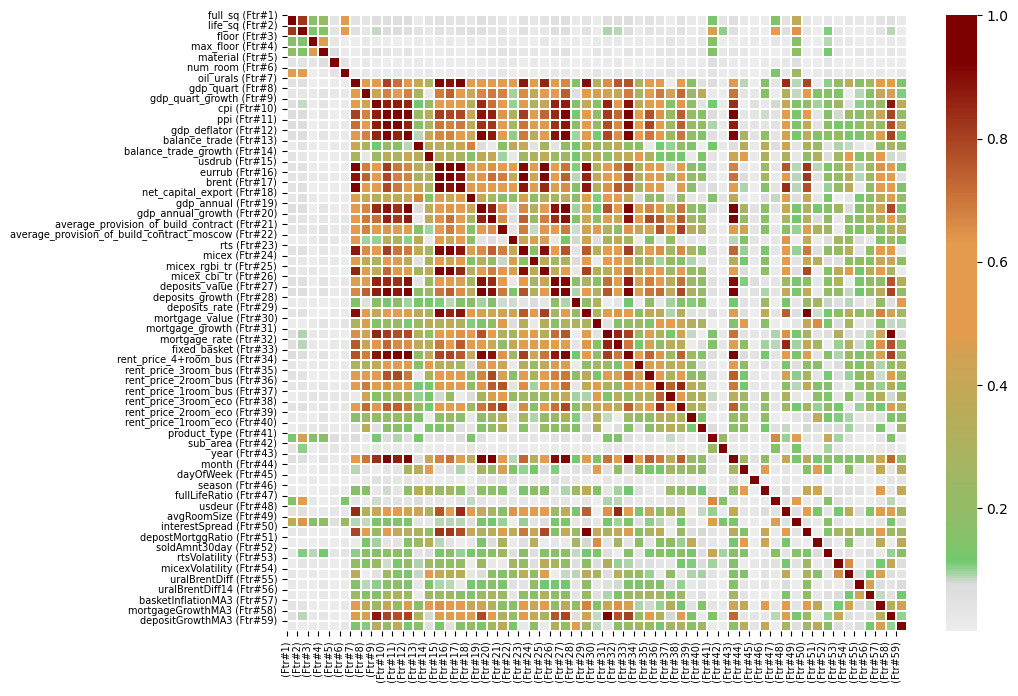

In [34]:
cmap_colors = ["#EDEDED", "#E4E4E4", "#DCDCDC", # grays
               "#72C96F", # green
               "#85C169", "#8FBD67", "#98BA64", "#A3B664", "#ABB25E", "#B5AE5B", "#BDAA58", "#C7A756", "#D0A353",# gradual transitions to orange
               "#E39B4D", "#E39B4D", "#E39B4D", "#E39B4D", "#E39B4D", # orange
               "#D68844", "#CA753A", "#BD6131", "#B04E27", "#A33B1E", "#972814", "#8A140B", # gradual transitions to red
               "#7D0101", "#7D0101", "#7D0101"] # red
custom_cmap = LSC.from_list('custom', cmap_colors)
corrMatrix = imputedEnhncTrain.drop(columns = ['timestamp', 'price_doc', 'logPrice']).corr().abs()
fig, axs = plt.subplots(figsize = (10, 8))
ylabels = [col + f' (Ftr#{i+1})' for i, col in enumerate(corrMatrix.columns)]
xlabels = [f' (Ftr#{i+1})' for i in range(corrMatrix.shape[0])]
sns.heatmap(corrMatrix, cmap = custom_cmap, linewidths = 0.1)
plt.xticks(ticks = range(corrMatrix.shape[1]), labels = xlabels, fontsize = 7)
plt.yticks(ticks = range(corrMatrix.shape[0]), labels = ylabels, fontsize = 7)
plt.show()

it is clear when looking at this correlation metrix that there are groups that correlate with one another in various levels.

we'll take into acount only the sevearly correlated features and filter out some of the features to lower the multicolinearity the features in the data have, doing so while taking into acount the importance level they have to not remove features that are important and helpful.

the importance level we'll get using the hyper-parameters we got in the baseline model just to have some relatively stable and apropriate footing.

In [35]:
randomForestParams = {
    'max_depth': 8,
    'min_samples_leaf': 9,
    'n_estimators': 200
}
importanceRndFrstModel = RFR(n_jobs=-1, random_state = 42, **randomForestParams)
importanceRndFrstModel.fit(xTrn, yTrn)
importance = pd.Series(importanceRndFrstModel.feature_importances_, index = xTrn.columns).sort_values(ascending = True)
importance = importance/importance.max()*100

groups = []
corr_threshold = 0.75
notInGroup = pd.Series([True for i in range(corrMatrix.shape[1])], index = corrMatrix.columns)

for feature in corrMatrix.columns:
    if not groups:
        groups.append([feature])
        notInGroup[feature] = False
    else:
        if notInGroup[feature]:
            currGroup = [feature]
            notInGroup[feature] = False
            for f in corrMatrix.columns:
                if (corrMatrix.loc[f, feature] >= corr_threshold) & (notInGroup[f]):
                    currGroup.append(f)
                    notInGroup[f] = False
            groups.append(currGroup)

rndFrst_xTrn = xTrn.copy(deep = True)
rndFrst_xVal = xVal.copy(deep = True)
rndFrst_imputedEnhncTrain = imputedEnhncTrain.copy(deep = True)
rndFrst_imputedEnhncTest = imputedEnhncTest.copy(deep = True)
rndFrst_corrMatrix = corrMatrix.copy(deep = True)

print(f'Feature Filteration Log - Enhanced Random Forest Model\n=======================================================\n    threshold = {corr_threshold}\n    features to keep = 3\n')

removed = []

for i, group in enumerate(groups):
    if len(group) == 1:
        print(f"Group {i+1}:\n    - the feature ['{group[0]}'] is not correlated enough to any other feature.")
    else:
        avgImportance = importance.loc[group].mean()
        # col2Keep = importance.loc[group].sort_values(ascending = False).head(min(3, len(group))).index
        col2Keep = importance.loc[group][importance.loc[group] >= avgImportance].index
        removed += [col for col in group if col not in col2Keep]
        rndFrst_imputedEnhncTrain = rndFrst_imputedEnhncTrain[[col for col in rndFrst_imputedEnhncTrain.columns if col not in [c for c in group if c not in col2Keep]]]
        rndFrst_imputedEnhncTest = rndFrst_imputedEnhncTest[[col for col in rndFrst_imputedEnhncTest.columns if col not in [c for c in group if c not in col2Keep]]]
        rndFrst_xTrn = rndFrst_xTrn[[col for col in rndFrst_xTrn.columns if col not in [c for c in group if c not in col2Keep]]]
        rndFrst_xVal = rndFrst_xVal[[col for col in rndFrst_xVal.columns if col not in [c for c in group if c not in col2Keep]]]
        rndFrst_corrMatrix = rndFrst_corrMatrix.loc[[col for col in rndFrst_corrMatrix.columns if col not in [c for c in group if c not in col2Keep]], [col for col in rndFrst_corrMatrix.columns if col not in [c for c in group if c not in col2Keep]]]
        print(f"Group {i+1}:\n    - features kept- {list(col2Keep)}\n    - features removed- {[col for col in group if col not in col2Keep]}")

print(f'removed features:\n    - {removed}')

Feature Filteration Log - Enhanced Random Forest Model
    threshold = 0.75
    features to keep = 3

Group 1:
    - the feature ['full_sq'] is not correlated enough to any other feature.
Group 2:
    - the feature ['life_sq'] is not correlated enough to any other feature.
Group 3:
    - the feature ['floor'] is not correlated enough to any other feature.
Group 4:
    - the feature ['max_floor'] is not correlated enough to any other feature.
Group 5:
    - the feature ['material'] is not correlated enough to any other feature.
Group 6:
    - the feature ['num_room'] is not correlated enough to any other feature.
Group 7:
    - features kept- ['usdrub', 'eurrub', 'brent', 'rts', 'micex_rgbi_tr', 'usdeur']
    - features removed- ['oil_urals', 'cpi', 'deposits_rate', 'mortgage_rate', 'fixed_basket', 'interestSpread']
Group 8:
    - the feature ['gdp_quart'] is not correlated enough to any other feature.
Group 9:
    - features kept- ['ppi', 'micex_cbi_tr']
    - features removed- ['gdp_q

the following features are the features we have left after filtering using our method

- **full_sq**
- **life_sq**
- **floor**
- **max_floor**
- **material**
- **num_room**
- **gdp_quart**
- **ppi**
- **balance_trade**
- **balance_trade_growth**
- **usdrub**
- **eurrub**
- **brent**
- **net_capital_export**
- **average_provision_of_build_contract**
- **average_provision_of_build_contract_moscow**
- **rts**
- **micex**
- **micex_rgbi_tr**
- **micex_cbi_tr**
- **deposits_growth**
- **mortgage_value**
- **rent_price_4+room_bus**
- **rent_price_2room_bus**
- **rent_price_1room_bus**
- **rent_price_2room_eco**
- **rent_price_1room_eco**
- **product_type**
- **sub_area**
- **price_doc**
- **timestamp**
- **logPrice**
- **month**
- **dayOfWeek**
- **season**
- **fullLifeRatio**
- **usdeur**
- **avgRoomSize**
- **depostMortggRatio**
- **soldAmnt30day**
- **rtsVolatility**
- **micexVolatility**
- **uralBrentDiff**
- **uralBrentDiff14**
- **basketInflationMA3**
- **depositGrowthMA3**

we should take a look at the importance levels and the updated correlation matrix to determin which features to keep for the model itself, since this is to many features which might act as noise catchers.

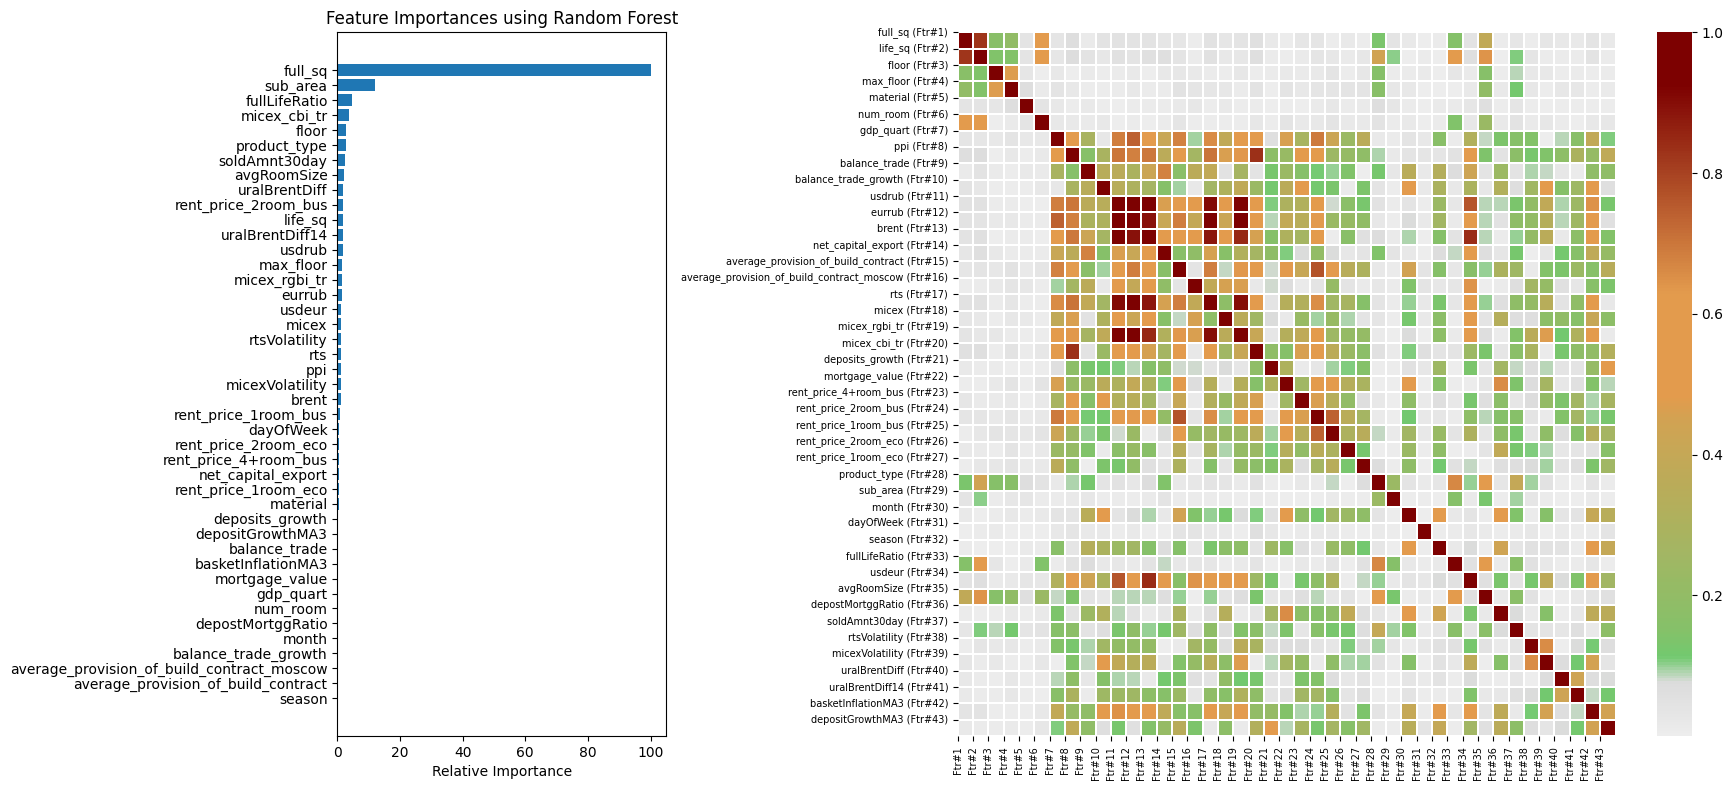

In [36]:
randomForestParams = {
    'max_depth': 8,
    'min_samples_leaf': 9,
    'n_estimators': 200
}
importanceRndFrstModel = RFR(n_jobs=-1, random_state = 42, **randomForestParams)
importanceRndFrstModel.fit(rndFrst_xTrn, yTrn)
importance = pd.Series(importanceRndFrstModel.feature_importances_, index = rndFrst_xTrn.columns).sort_values(ascending = True)
importance = importance/importance.max()*100

fig = plt.figure(figsize = (18, 8))
gs = GS.GridSpec(1, 2, width_ratios=[2, 5])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_title('Feature Importances using Random Forest')
ax0.barh(importance.index, importance.values, align='center')
ax0.set_xlabel('Relative Importance')

corrMatrixTicks = range(rndFrst_corrMatrix.shape[0])
ylabels = [col + f' (Ftr#{i+1})' for i, col in enumerate(rndFrst_corrMatrix.columns)]
xlabels = [f'Ftr#{i+1}' for i in corrMatrixTicks]
sns.heatmap(rndFrst_corrMatrix, cmap = custom_cmap, linewidths = 0.1, ax=ax1)
ax1.set_xticks(ticks = corrMatrixTicks)
ax1.set_xticklabels(labels = xlabels, fontsize = 7)
ax1.set_yticks(ticks = corrMatrixTicks)
ax1.set_yticklabels(labels = ylabels, fontsize = 7)

plt.tight_layout()
plt.show()

it is very clear that full_sq is the most important feature, and that sub_area and fullLifeRatio are the second and third most important features respectively.

the rest of the features, even though they have an order of their usefulness to the model, determined by their importance, it is hard to say if they have any significance to the model.

but keeping only 3 features seem to be lacking, so to be sure we decided to also keep the top 7 features after full_sq, sub_area and fullLifeRatio, leaving us with 10 features to model upon.

In [37]:
rndFrst_features2drop = importance.head(importance.shape[0] - 10).index

rndFrst_xTrn.drop(columns = rndFrst_features2drop, inplace = True)
rndFrst_xVal.drop(columns = rndFrst_features2drop, inplace = True)
rndFrst_imputedEnhncTrain.drop(columns = rndFrst_features2drop, inplace = True)
rndFrst_imputedEnhncTest.drop(columns = rndFrst_features2drop, inplace = True)

since the baseline model we made had almost all of its hyper-parameters picked as the maximum value available to the cross validation process, we'll perform the cross validation on a higher and wider range of values.

In [38]:
# enhncRndFrstParams = {
#     'max_depth': [i for i in range(6, 17, 2)], # 6, 8, 10, 12, 14, 16
#     'min_samples_leaf': [i for i in range(8, 44, 7)], # 8, 15, 22, 29, 36, 43
#     'n_estimators': [i for i in range(175, 426, 50)] # 175, 225, 275, 325, 375, 425
# }
# enhncRndFrstModel = RFR()
# enhncRndFrstGrdSrch = GSCV(enhncRndFrstModel, enhncRndFrstParams, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2)
# enhncRndFrstGrdSrch.fit(rndFrst_xTrn, yTrn)

# enhncRndFrstModelParams = enhncRndFrstGrdSrch.best_params_

# enhncRndFrstOptModel = RFR(**enhncRndFrstModelParams)
# enhncRndFrstOptModel.fit(rndFrst_xTrn, yTrn)

In [39]:
shortcutParams = {
    'max_depth': 12,
    'min_samples_leaf': 8,
    'n_estimators': 375
}
enhncRndFrstOptModel = RFR(**shortcutParams)
enhncRndFrstOptModel.fit(rndFrst_xTrn, yTrn)

RandomForestRegressor(max_depth=12, min_samples_leaf=8, n_estimators=375)

In [40]:
enhncRndFrstMseScores = -1 * CVS(enhncRndFrstOptModel, rndFrst_xVal, yVal, cv = 5, scoring = 'neg_mean_squared_error')
enhncRndFrstPred = enhncRndFrstOptModel.predict(rndFrst_xVal)
enhncRndFrstRmsle = np.sqrt(np.mean((enhncRndFrstPred - yVal) ** 2))
enhncRndFrstR2 = enhncRndFrstOptModel.score(rndFrst_xVal, yVal)

metrics.loc[metrics.shape[0]] = {'Model': 'Enhanced Random Forest Model',
                                 'MSE': enhncRndFrstMseScores.mean(),
                                 'RMSLE': enhncRndFrstRmsle,
                                 'R^2': enhncRndFrstR2}

display(metrics)

,Model,MSE,RMSLE,R^2
0,Random Forest Model,0.193226,0.448706,0.411025
1,XGBoost Model,0.181838,0.432900,0.451788
2,Enhanced Random Forest Model,0.254910,0.506099,0.325930


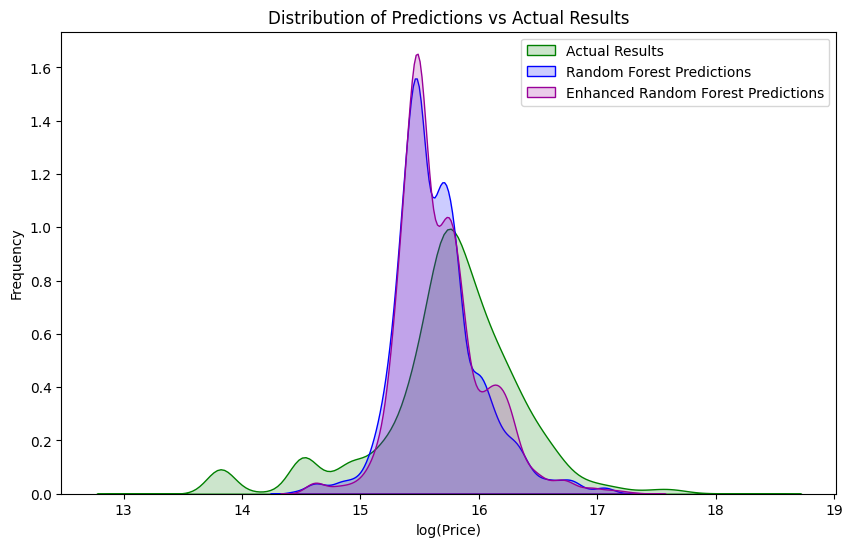

In [41]:
# random forest comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(yVal, color = 'green', fill = True, alpha = 0.2, label='Actual Results')
sns.kdeplot(rndFrstPred, color = 'blue', fill = True, alpha = 0.2, label='Baseline Random Forest Predictions')
sns.kdeplot(enhncRndFrstPred, color = '#990099', fill = True, alpha = 0.2, label='Enhanced Random Forest Predictions')
plt.xlabel('log(Price)')
plt.ylabel('Frequency')
plt.title('Distribution of Random Forest Models Predictions vs Actual Results')
plt.legend()
plt.show()

In [42]:
yPredEnhncRndFrst = np.round(np.exp(enhncRndFrstOptModel.predict(rndFrst_imputedEnhncTest.drop(columns = ['id', 'timestamp']))), decimals = -3)
enhncRndFrstSubmission = pd.DataFrame({'id': rndFrst_imputedEnhncTest.id, 'price_doc': yPredEnhncRndFrst})
enhncRndFrstSubmission.to_csv('EnhancedRandomForestSubmission.csv', index = False)

when submitting the predictions test data we get the following results in comparison to previous models:
|  | Private Score | Public Score |
| - | - | - |
| Random Forest Model | 0.38083 | 0.38305 |
| XGBoost Model | 0.36470 | 0.36667 |
| Enhanced Random Forest Model | 0.37430 | 0.37120 |

we can see that in comparison to the baseline random forest model our enhanced model has improved!

# 4. Advanced Modeling
## a. Model Implementation
now we should implement the model under XGBoost framework, this is because rather than building a Random Forest model which relys on Bagging, XGBoost (as its name suggests) relys on Boosting.

the main differences between Boosting and Bagging are as follows:

**Bagging** is a method that builds multiple decision trees without any concern of what other decision trees concluded, each decision tree is trained on a random set of the training data and features, and the result is an aggregation of the results of each tree (in this case an average due to it being a regression problem).

**Boosting** on the other hand builds multiple decision trees which rely on each-other and try to correct the precious tree's prediction, the result at the end is the result of the last tree which gives out a corrected result of the precious tree.

the main reason to not start before hand with XGBoost is it being very time consuming compared to Random Forest, that because Random Forest can make its decision trees in parallel without having any concern on the results of other trees, its trees do not have an order of some sort, but in XGBoost each tree relys on the previous one and can start only when the previous tree finished.

so lets implement an XGBoost model

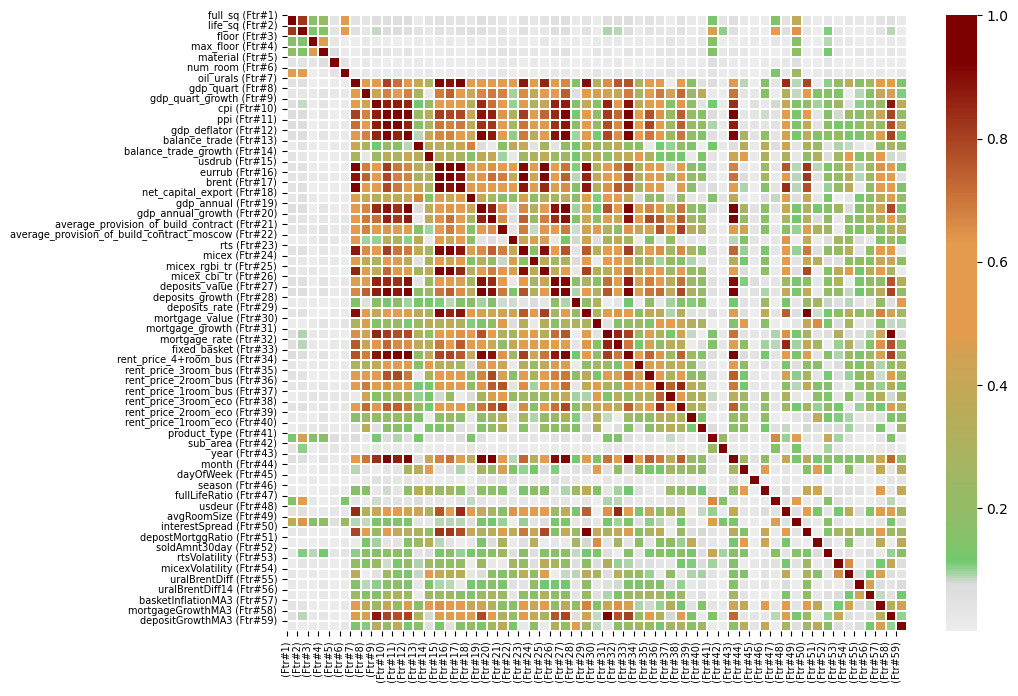

In [43]:
fig, axs = plt.subplots(figsize = (10, 8))
ylabels = [col + f' (Ftr#{i+1})' for i, col in enumerate(corrMatrix.columns)]
xlabels = [f' (Ftr#{i+1})' for i in range(corrMatrix.shape[0])]
sns.heatmap(corrMatrix, cmap = custom_cmap, linewidths = 0.1)
plt.xticks(ticks = range(corrMatrix.shape[1]), labels = xlabels, fontsize = 7)
plt.yticks(ticks = range(corrMatrix.shape[0]), labels = ylabels, fontsize = 7)
plt.show()

In [44]:
XGBoostParams = {
    'learning_rate': 0.014,
    'max_depth': 12,
    'min_samples_leaf': 8,
    'n_estimators': 375,
    'subsample': 0.65
}

importanceXGBModel = GBR(**XGBoostParams)
importanceXGBModel.fit(xTrn, yTrn)
importance = pd.Series(importanceXGBModel.feature_importances_, index = xTrn.columns).sort_values(ascending = True)
importance = importance/importance.max()*100

groups = []
corr_threshold = 0.75
notInGroup = pd.Series([True for i in range(corrMatrix.shape[1])], index = corrMatrix.columns)

for feature in corrMatrix.columns:
    if not groups:
        groups.append([feature])
        notInGroup[feature] = False
    else:
        if notInGroup[feature]:
            currGroup = [feature]
            notInGroup[feature] = False
            for f in corrMatrix.columns:
                if (corrMatrix.loc[f, feature] >= corr_threshold) & (notInGroup[f]):
                    currGroup.append(f)
                    notInGroup[f] = False
            groups.append(currGroup)

xgb_xTrn = xTrn.copy(deep = True)
xgb_xVal = xVal.copy(deep = True)
xgb_imputedEnhncTrain = imputedEnhncTrain.copy(deep = True)
xgb_imputedEnhncTest = imputedEnhncTest.copy(deep = True)
xgb_corrMatrix = corrMatrix.copy(deep = True)

print(f'Feature Filteration Log - Enhanced XGBoost Model\n=================================================\n    threshold = {corr_threshold}\n    features to keep = 3\n')

removed = []

for i, group in enumerate(groups):
    if len(group) == 1:
        print(f"Group {i+1}:\n    - the feature ['{group[0]}'] is not correlated enough to any other feature.")
    else:
        avgImportance = importance.loc[group].mean()
        # col2Keep = importance.loc[group].sort_values(ascending = False).head(min(3, len(group))).index
        col2Keep = importance.loc[group][importance.loc[group] >= avgImportance].index
        removed += [col for col in group if col not in col2Keep]
        xgb_imputedEnhncTrain = xgb_imputedEnhncTrain[[col for col in xgb_imputedEnhncTrain.columns if col not in [c for c in group if c not in col2Keep]]]
        xgb_imputedEnhncTest = xgb_imputedEnhncTest[[col for col in xgb_imputedEnhncTest.columns if col not in [c for c in group if c not in col2Keep]]]
        xgb_xTrn = xgb_xTrn[[col for col in xgb_xTrn.columns if col not in [c for c in group if c not in col2Keep]]]
        xgb_xVal = xgb_xVal[[col for col in xgb_xVal.columns if col not in [c for c in group if c not in col2Keep]]]
        xgb_corrMatrix = xgb_corrMatrix.loc[[col for col in xgb_corrMatrix.columns if col not in [c for c in group if c not in col2Keep]], [col for col in xgb_corrMatrix.columns if col not in [c for c in group if c not in col2Keep]]]
        print(f"Group {i+1}:\n    - features kept- {list(col2Keep)}\n    - features removed- {[col for col in group if col not in col2Keep]}")

print(f'removed features:\n    - {removed}')

Feature Filteration Log - Enhanced XGBoost Model
    threshold = 0.75
    features to keep = 3

Group 1:
    - the feature ['full_sq'] is not correlated enough to any other feature.
Group 2:
    - the feature ['life_sq'] is not correlated enough to any other feature.
Group 3:
    - the feature ['floor'] is not correlated enough to any other feature.
Group 4:
    - the feature ['max_floor'] is not correlated enough to any other feature.
Group 5:
    - the feature ['material'] is not correlated enough to any other feature.
Group 6:
    - the feature ['num_room'] is not correlated enough to any other feature.
Group 7:
    - features kept- ['usdrub', 'eurrub', 'brent', 'rts', 'micex_rgbi_tr', 'usdeur']
    - features removed- ['oil_urals', 'cpi', 'deposits_rate', 'mortgage_rate', 'fixed_basket', 'interestSpread']
Group 8:
    - the feature ['gdp_quart'] is not correlated enough to any other feature.
Group 9:
    - features kept- ['micex_cbi_tr']
    - features removed- ['gdp_quart_growth',

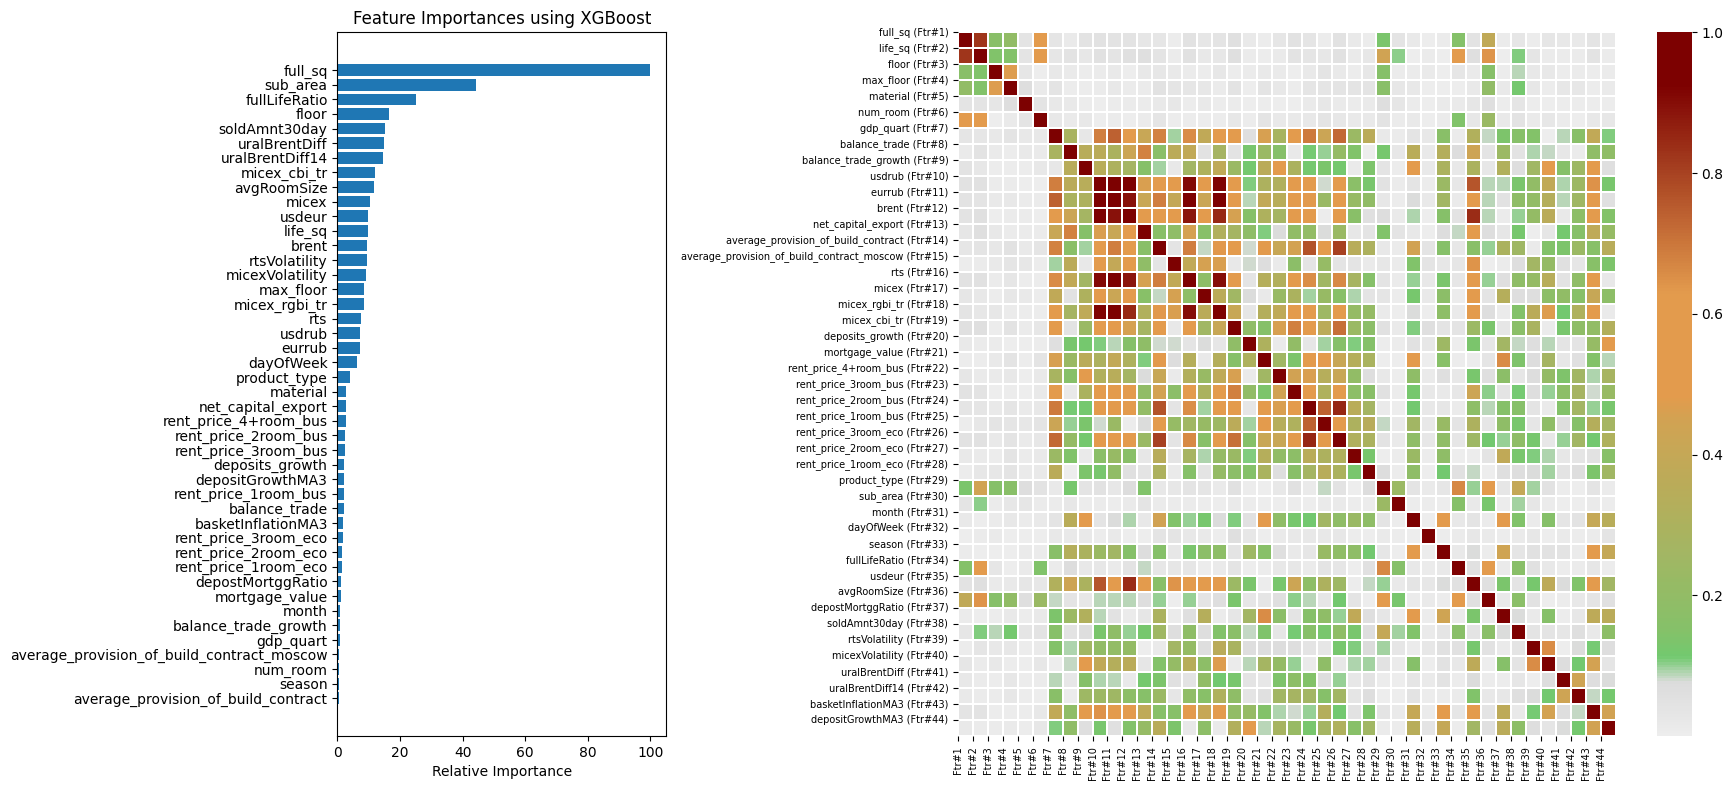

In [45]:
XGBoostParams = {
    'learning_rate': 0.014,
    'max_depth': 12,
    'min_samples_leaf': 8,
    'n_estimators': 375,
    'subsample': 0.65
}

importanceXGBModel = GBR(**XGBoostParams)
importanceXGBModel.fit(xgb_xTrn, yTrn)
importance = pd.Series(importanceXGBModel.feature_importances_, index = xgb_xTrn.columns).sort_values(ascending = True)
importance = importance/importance.max()*100

fig = plt.figure(figsize = (18, 8))
gs = GS.GridSpec(1, 2, width_ratios=[2, 5])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_title('Feature Importances using XGBoost')
ax0.barh(importance.index, importance.values, align='center')
ax0.set_xlabel('Relative Importance')

corrMatrixTicks = range(xgb_corrMatrix.shape[0])
ylabels = [col + f' (Ftr#{i+1})' for i, col in enumerate(xgb_corrMatrix.columns)]
xlabels = [f'Ftr#{i+1}' for i in corrMatrixTicks]
sns.heatmap(xgb_corrMatrix, cmap = custom_cmap, linewidths = 0.1, ax=ax1)
ax1.set_xticks(ticks = corrMatrixTicks)
ax1.set_xticklabels(labels = xlabels, fontsize = 7)
ax1.set_yticks(ticks = corrMatrixTicks)
ax1.set_yticklabels(labels = ylabels, fontsize = 7)

plt.tight_layout()
plt.show()

we can see that much less of the features were removed here, and its clear why, while filtering the features (using XGBoost this time) the model gave many features higher importance levels than they had before (using Random Forest).

and it seems that many of the features should be included, we'll keep all 21 of them.

In [46]:
xgb_features2drop = importance.head(importance.shape[0] - 21).index

xgb_xTrn.drop(columns = xgb_features2drop, inplace = True)
xgb_xVal.drop(columns = xgb_features2drop, inplace = True)
xgb_imputedEnhncTrain.drop(columns = xgb_features2drop, inplace = True)
xgb_imputedEnhncTest.drop(columns = xgb_features2drop, inplace = True)

since we got better value in the enhanced Random Forest model we should use them as a base to ground our search for better hyper-parameters.

the hyper-parameters that are not present in the Random forest were almost at the edges of the ranges that were set to them, so like in the enhanced Random Forest model we'll perform the cross validation on a wider and better suited range of values.

In [47]:
# enhncXGBoostParams = {
#     'learning_rate': [i/1000 for i in range(11, 18, 2)], # 0.011, 0.013, 0.015, 0.017
#     'n_estimators': [i for i in range(350, 401, 25)], # 350, 375, 400
#     'subsample': [i/20 for i in range(12, 16)], # 0.6, 0.65, 0.7, 0.75
#     'max_depth': [i for i in range(9, 16, 3)], # 9, 12, 15
#     'min_samples_leaf': [i for i in range(7, 11)] # 7, 8, 9, 10
# }

# enhncXGBoostGrdSrch = GSCV(GBR(), enhncXGBoostParams, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2)
# enhncXGBoostGrdSrch.fit(xgb_xTrn, yTrn)

# enhncXGBoostModelParams = enhncXGBoostGrdSrch.best_params_

# enhncXGBoostOptModel = GBR(**enhncXGBoostModelParams)
# enhncXGBoostOptModel.fit(xgb_xTrn, yTrn)

In [48]:
# need to update
shortcutParams = {
    'learning_rate': 0.011,
    'n_estimators': 400,
    'subsample': 0.75,
    'max_depth': 9,
    'min_samples_leaf': 10
}

enhncXGBoostOptModel = GBR(**shortcutParams)
enhncXGBoostOptModel.fit(xgb_xTrn, yTrn)

GradientBoostingRegressor(learning_rate=0.011, max_depth=9, min_samples_leaf=10,
                          n_estimators=400, subsample=0.75)

## b. Evaluation and Comparison

In [49]:
enhncXGBoostMseScores = -1 * CVS(enhncXGBoostOptModel, xgb_xVal, yVal, cv = 5, scoring = 'neg_mean_squared_error')
enhncXGBoostPred = enhncXGBoostOptModel.predict(xgb_xVal)
enhncXGBoostRmsle = np.sqrt(np.mean((enhncXGBoostPred - yVal) ** 2))
enhncXGBoostR2 = enhncXGBoostOptModel.score(xgb_xVal, yVal)

metrics.loc[metrics.shape[0]] = {'Model': 'Enhanced XGBoost Model',
                                 'MSE': enhncXGBoostMseScores.mean(),
                                 'RMSLE': enhncXGBoostRmsle,
                                 'R^2': enhncXGBoostR2}

display(metrics)

,Model,MSE,RMSLE,R^2
0,Random Forest Model,0.193226,0.448706,0.411025
1,XGBoost Model,0.181838,0.432900,0.451788
2,Enhanced Random Forest Model,0.254910,0.506099,0.325930
3,Enhanced XGBoost Model,0.249461,0.515581,0.300434


we can see here in our validation performance metrics that this model seem to be worse under the RMSLE, which is the metric of the competition, but it did get better MSE, so there is a reason to be a little optimistic

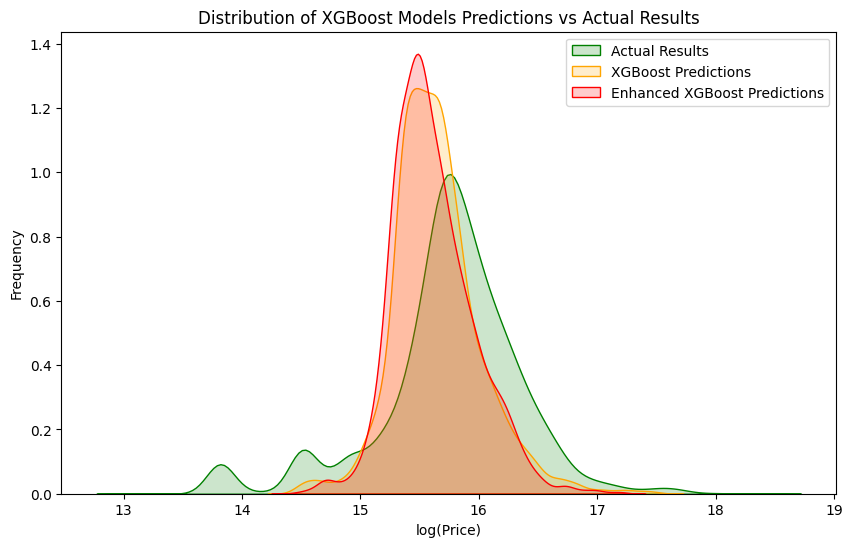

In [52]:
# xgboost comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(yVal, color = 'green', fill = True, alpha = 0.2, label='Actual Results')
sns.kdeplot(xgbPred, color = 'orange', fill = True, alpha = 0.2, label='Baseline XGBoost Predictions')
sns.kdeplot(enhncXGBoostPred, color = 'red', fill = True, alpha = 0.2, label='Enhanced XGBoost Predictions')
plt.xlabel('log(Price)')
plt.ylabel('Frequency')
plt.title('Distribution of XGBoost Models Predictions vs Actual Results')
plt.legend()
plt.show()

looking at the distributions we see that the new distribtuion has a higher peek than any other distribution in the context of XGBoost, also seem to be worse than it should to be called improved

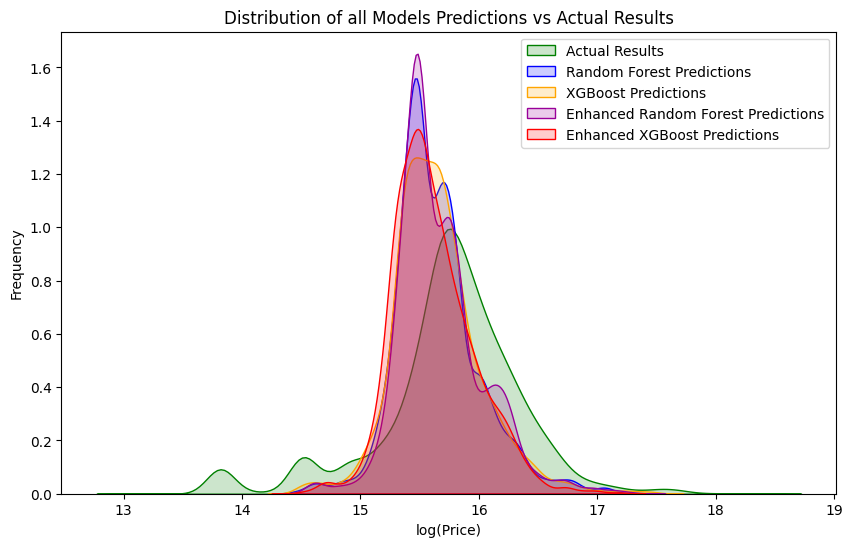

In [53]:
# all comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(yVal, color = 'green', fill = True, alpha = 0.2, label='Actual Results')
sns.kdeplot(rndFrstPred, color = 'blue', fill = True, alpha = 0.2, label='Baseline Random Forest Predictions')
sns.kdeplot(xgbPred, color = 'orange', fill = True, alpha = 0.2, label='Baseline XGBoost Predictions')
sns.kdeplot(enhncRndFrstPred, color = '#990099', fill = True, alpha = 0.2, label='Enhanced Random Forest Predictions')
sns.kdeplot(enhncXGBoostPred, color = 'red', fill = True, alpha = 0.2, label='Enhanced XGBoost Predictions')
plt.xlabel('log(Price)')
plt.ylabel('Frequency')
plt.title('Distribution of all Models Predictions vs Actual Results')
plt.legend()
plt.show()

but still in comparison to all models, it is not the 'pointiest', but it is the most right-squed, which gives of a passimistic approach to its final performance in the competition

In [51]:
yPredEnhncXGBoost = np.round(np.exp(enhncXGBoostOptModel.predict(xgb_imputedEnhncTest.drop(columns = ['id', 'timestamp']))), decimals = -3)
enhncXGBoostSubmission = pd.DataFrame({'id': xgb_imputedEnhncTest.id, 'price_doc': yPredEnhncXGBoost})
enhncXGBoostSubmission.to_csv('EnhancedXGBoostSubmission.csv', index = False)

when submitting the predictions test data we get the following results in comparison to previous models:
|  | Private Score | Public Score |
| - | - | - |
| Random Forest Model | 0.38083 | 0.38305 |
| XGBoost Model | 0.36470 | 0.36667 |
| Enhanced Random Forest Model | 0.37430 | 0.37120 |
| Enhanced XGBoost Model | 0.39671 | 0.39527 |

as expected to our graphs and metrics, the new XGBoost model did not improve upon the previous models, and even more, it is the worst model yet!

# 5. State-Of-The-Art Techniques
## a. Technique Exploration


## b. Application and Performance
discussing and explaining the works of these techniques, how and why they work.

###### maybe even implement them within our project.

# Presentation
#### Details
5-minute powerpoint presentation that describes the most interesting turning points in the project

i think we should include the saving of rows when data cleaning.

# Grading Criteria
- **Clarity and organization:**

    the report (presentation and PDF) should have structure and clear in the writing to make it easier for the readers to understand the process and findings
- **Comprehensiveness:**

    the report (presentation and PDF) should cover all aspects of the tasks having detailed explanations of our approach, analysis and conclusions
- **Innovation:**

    Creativity and originality is encouraged
- **Accuracy and Performance:**

    we need to show the improvement of the models when implementing the methodologies and compare the original results with the new ones
- **Relative Performance Evaluation:**

    the final grade is also assigned based on the performance in the course (sounds like bullshit because they dont have a way to check our performance in the course if attendance is was not a must)